# Eigen-decomposition of human sperm sex chromosome separated samples

Here, we prep the E1 values of the data from the human sperm sex chromosome separated samples.

In [1]:
import bioframe
import cooler
import numpy as np
import pandas as pd
import os
import subprocess
from pathlib import Path
import warnings
from typing import Union
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
from functools import partial
from tqdm.auto import tqdm, trange

from geneinfo.plot import GenomeIdeogram, ChromIdeogram
from geneinfo.genelist import GeneListCollection
from geneinfo.genelist import GeneList as glist
from geneinfo.coords import gene_labels
from genome_intervals.intervals import interval_diff, interval_collapse, interval_intersect, interval_union

import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = 'svg'
from vscodenb import set_vscode_theme, vscode_theme, pqdm, prange
set_vscode_theme()

<Figure size 640x480 with 0 Axes>

In [2]:
assembly = "GRCh38"

In [3]:
chromosomes = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']
bin_sizes = [1000, 5000, 10000, 50000, 100000, 500000]

Create views:

In [4]:
os.makedirs("../steps/views/", exist_ok=True)
centromeres = bioframe.fetch_centromeres(assembly)
chromsizes = bioframe.fetch_chromsizes(assembly)
chromarms = bioframe.make_chromarms(chromsizes, centromeres)
views = {}
for chrom in chromosomes:
    path = f"../steps/views/view_{assembly}_{chrom}_chromarms.tsv"
    views[chrom] = path
    bioframe.make_viewframe(chromarms).query(f'chrom == "{chrom}"').to_csv(path, index=False, header=False, sep='\t')

Calculate the GC content:


In [5]:

reference_genome = '../steps/reference/hg38.fa'

os.makedirs("../steps/bins/", exist_ok=True)
for bin_size in tqdm(bin_sizes):
    records = []
    for chrom, length in tqdm(dict(chromsizes).items(), leave=False):
        for i in range(0, length, bin_size):
            records.append((chrom, i, min(i+bin_size, length)))
    bins_file_name = f"../steps/bins/hg38.bins.{bin_size}.tsv"
    if os.path.exists(bins_file_name):
        continue
    with open(bins_file_name, 'w') as f:
        pd.DataFrame.from_records(records, columns=['chrom', 'start', 'end']).to_csv(f, index=False, sep='\t')
    gc_file_name = bins_file_name.replace(".bins.", ".gc.")
    subprocess.run(f'pixi run cooltools genome gc {bins_file_name} {reference_genome} > {gc_file_name}', shell=True, check=True)
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Do eigendecomposition:

In [ ]:
import subprocess
from pathlib import Path

#resolutions = [1000, 5000, 10000, 50000, 100000, 500000]
resolutions = [100000]

os.makedirs('../steps/eigs/', exist_ok=True)
for res in tqdm(list(reversed(resolutions)), leave=False):
    for chrom in tqdm(chromosomes[:22], leave=False):
        for tissue in ['sperm_X', 'sperm_Y']:
            cooler = f"../steps/merged/{tissue}.merged.mcool::resolutions/{res}"
            gc_bins = f"../steps/bins/hg38.gc.{res}.tsv"
            eigs_out = f"../steps/eigs/{tissue}_{chrom}.eigs.{res}"
            subprocess.run([
                "cooltools", "eigs-cis",
                "-o", eigs_out,
                "--view", views[chrom],
                "--phasing-track", gc_bins,
                "--n-eigs", "3",
                cooler
            ], capture_output=True, check=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

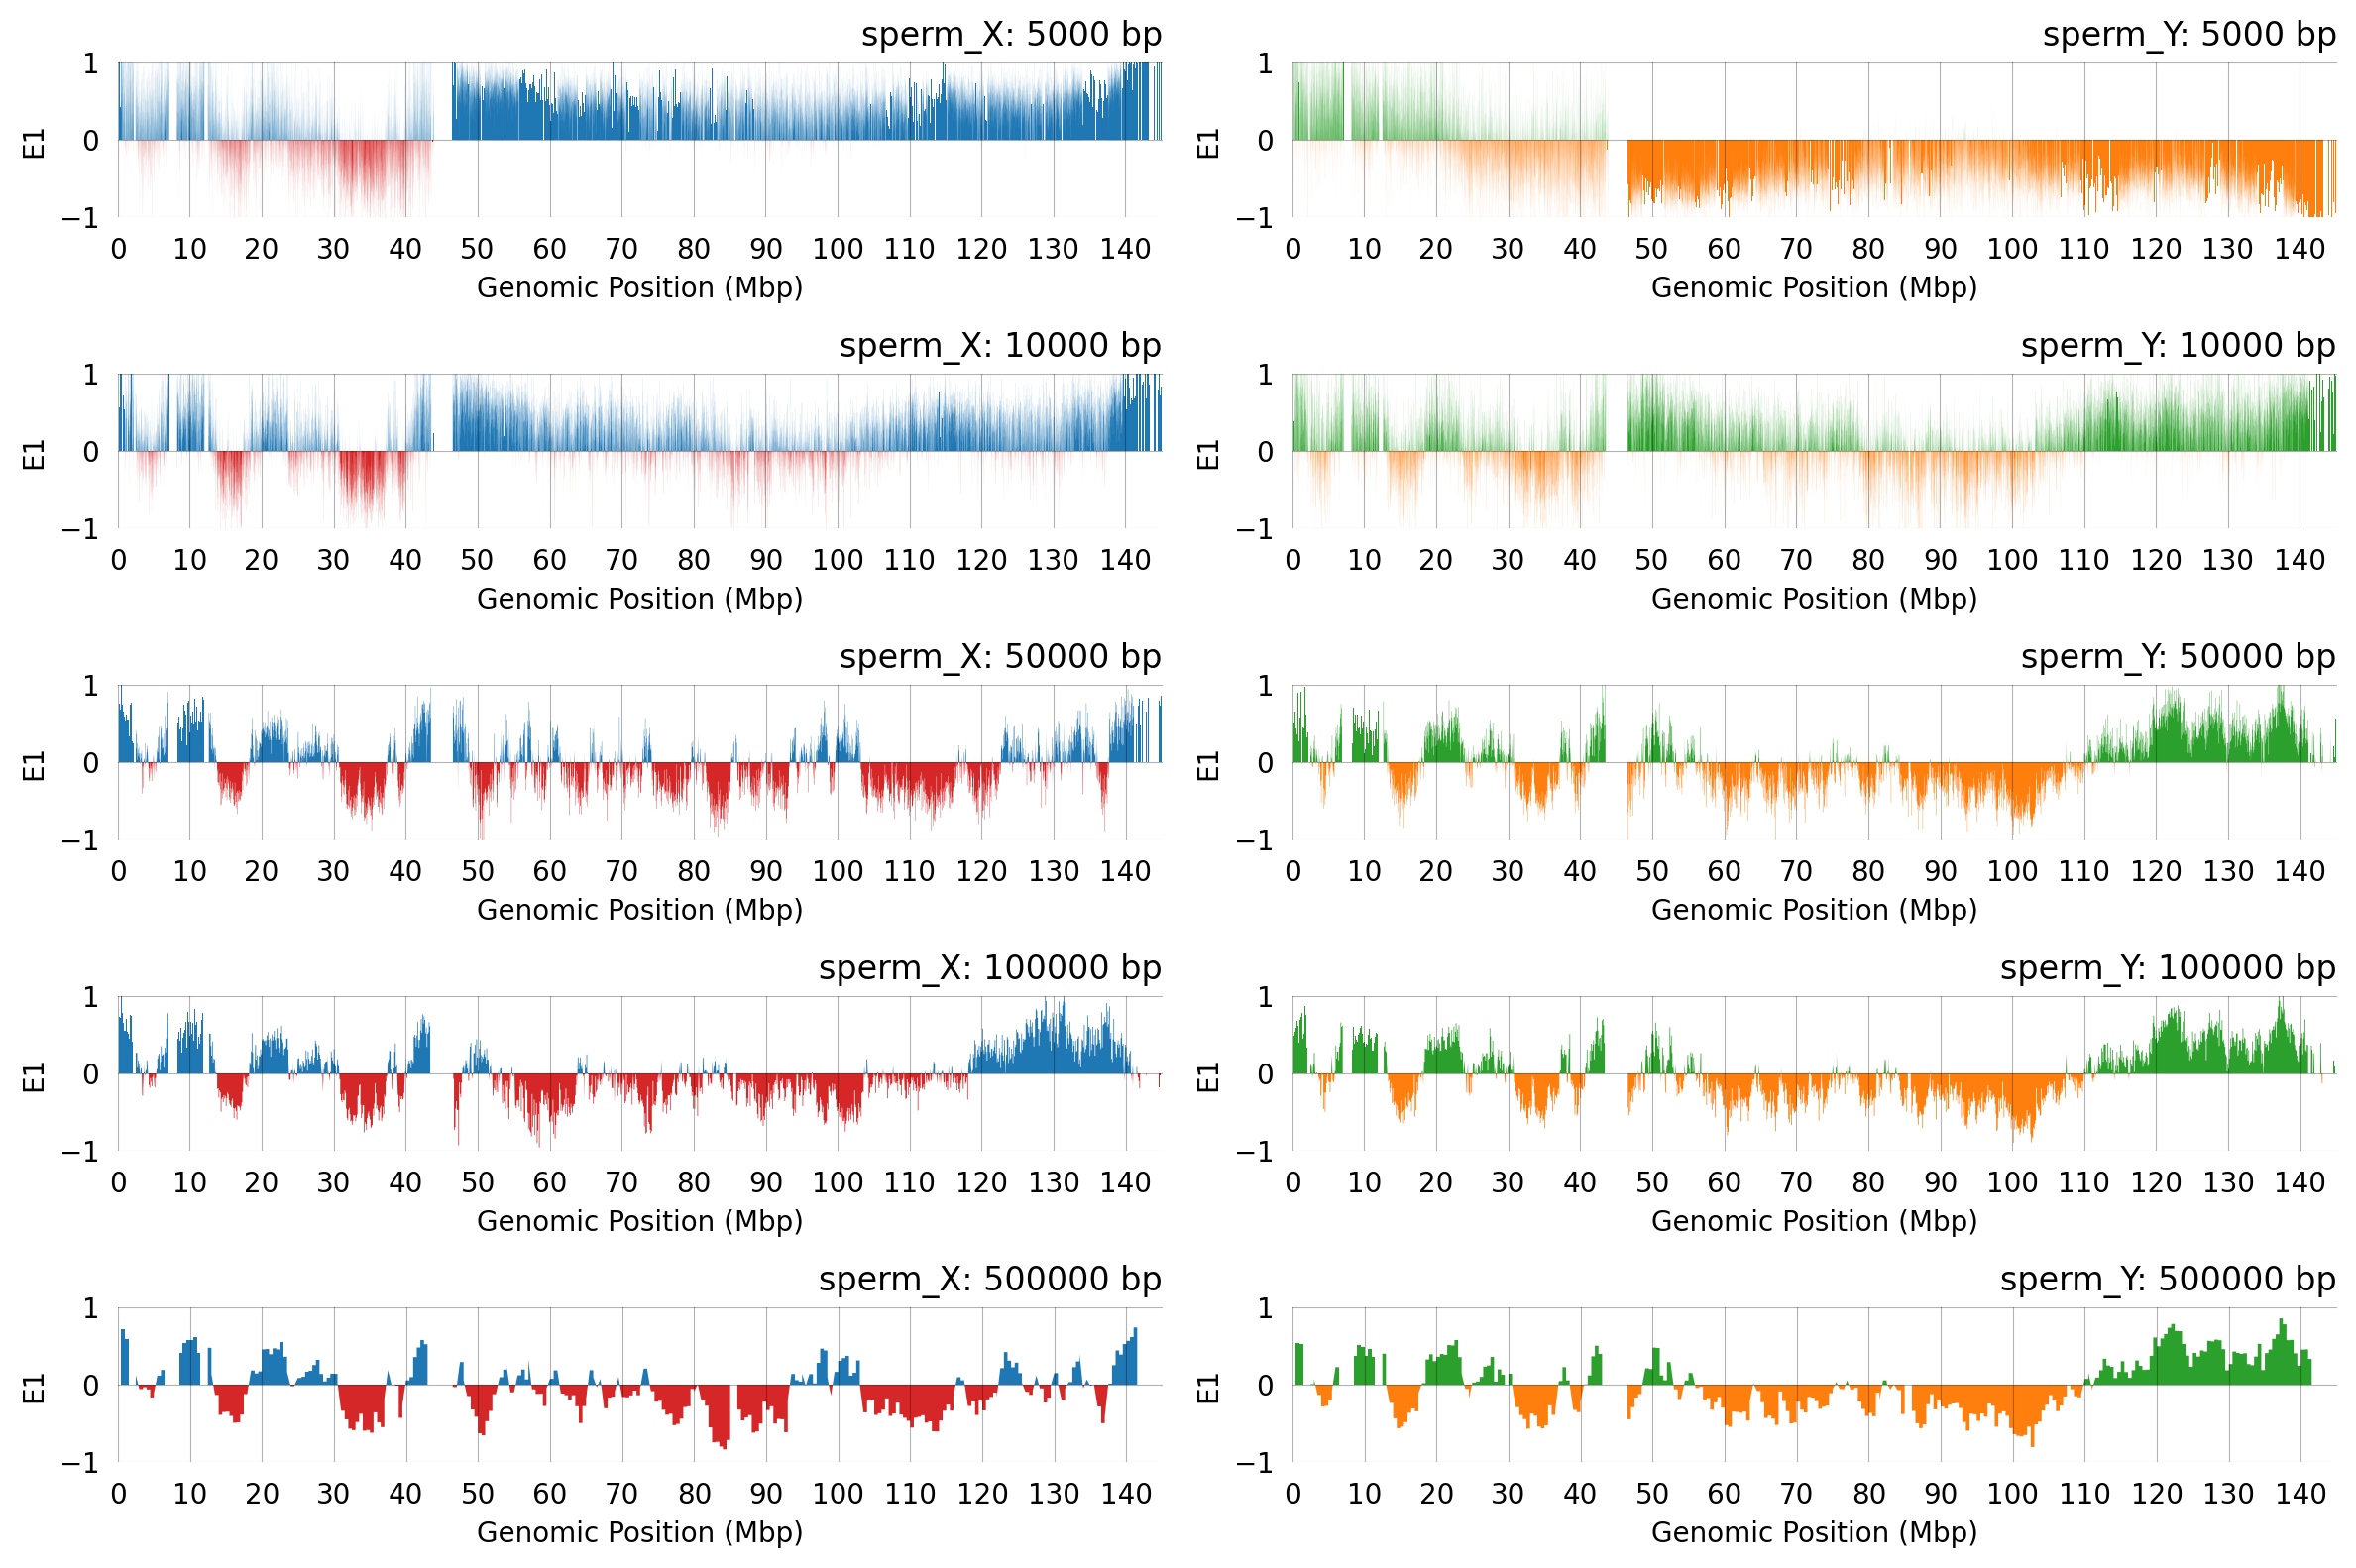

In [ ]:
resolutions = [5000, 10000, 50000, 100000, 500000]
chrom = 'chr8'
eig = 'E1'

with vscode_theme(style='grid'):
    fig, axes = plt.subplots(len(resolutions), 2, figsize=(12, 8))
    for i, resolution in enumerate(resolutions):
        for j, tissue in enumerate(['sperm_X', 'sperm_Y']):

            ax = axes[i, j]
            path = f"../steps/eigs/{tissue}_{chrom}.eigs.{resolution}.cis.vecs.tsv"
            df = pd.read_csv(path, sep="\t", header=0)
            x = df['start']
            y = df[eig]
            A_color = 'tab:red' if tissue == 'sperm_X' else 'tab:orange'
            B_color = 'tab:blue' if tissue == 'sperm_X' else 'tab:green'
            ax.fill_between(x, y, where = y<0, color=A_color, lw=1, ec='None', step='post', interpolate=True, label=f'A: {tissue}')
            ax.fill_between(x, y, where = y>0, color=B_color, lw=1, ec='None', step='post', interpolate=True, label=f'B: {tissue}')             
            ax.set_title(f'{tissue}: {resolution} bp')
            ax.set_ylabel(eig)
            ax.set_xlim(x.min(), x.max())
            ax.set_ylim(-1,1)
            ax.set_xlabel('Genomic Position (Mbp)')

            ticks = np.arange(0, x.max(), step=10_000_000)
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{int(t/1e6)}' for t in ticks])

    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

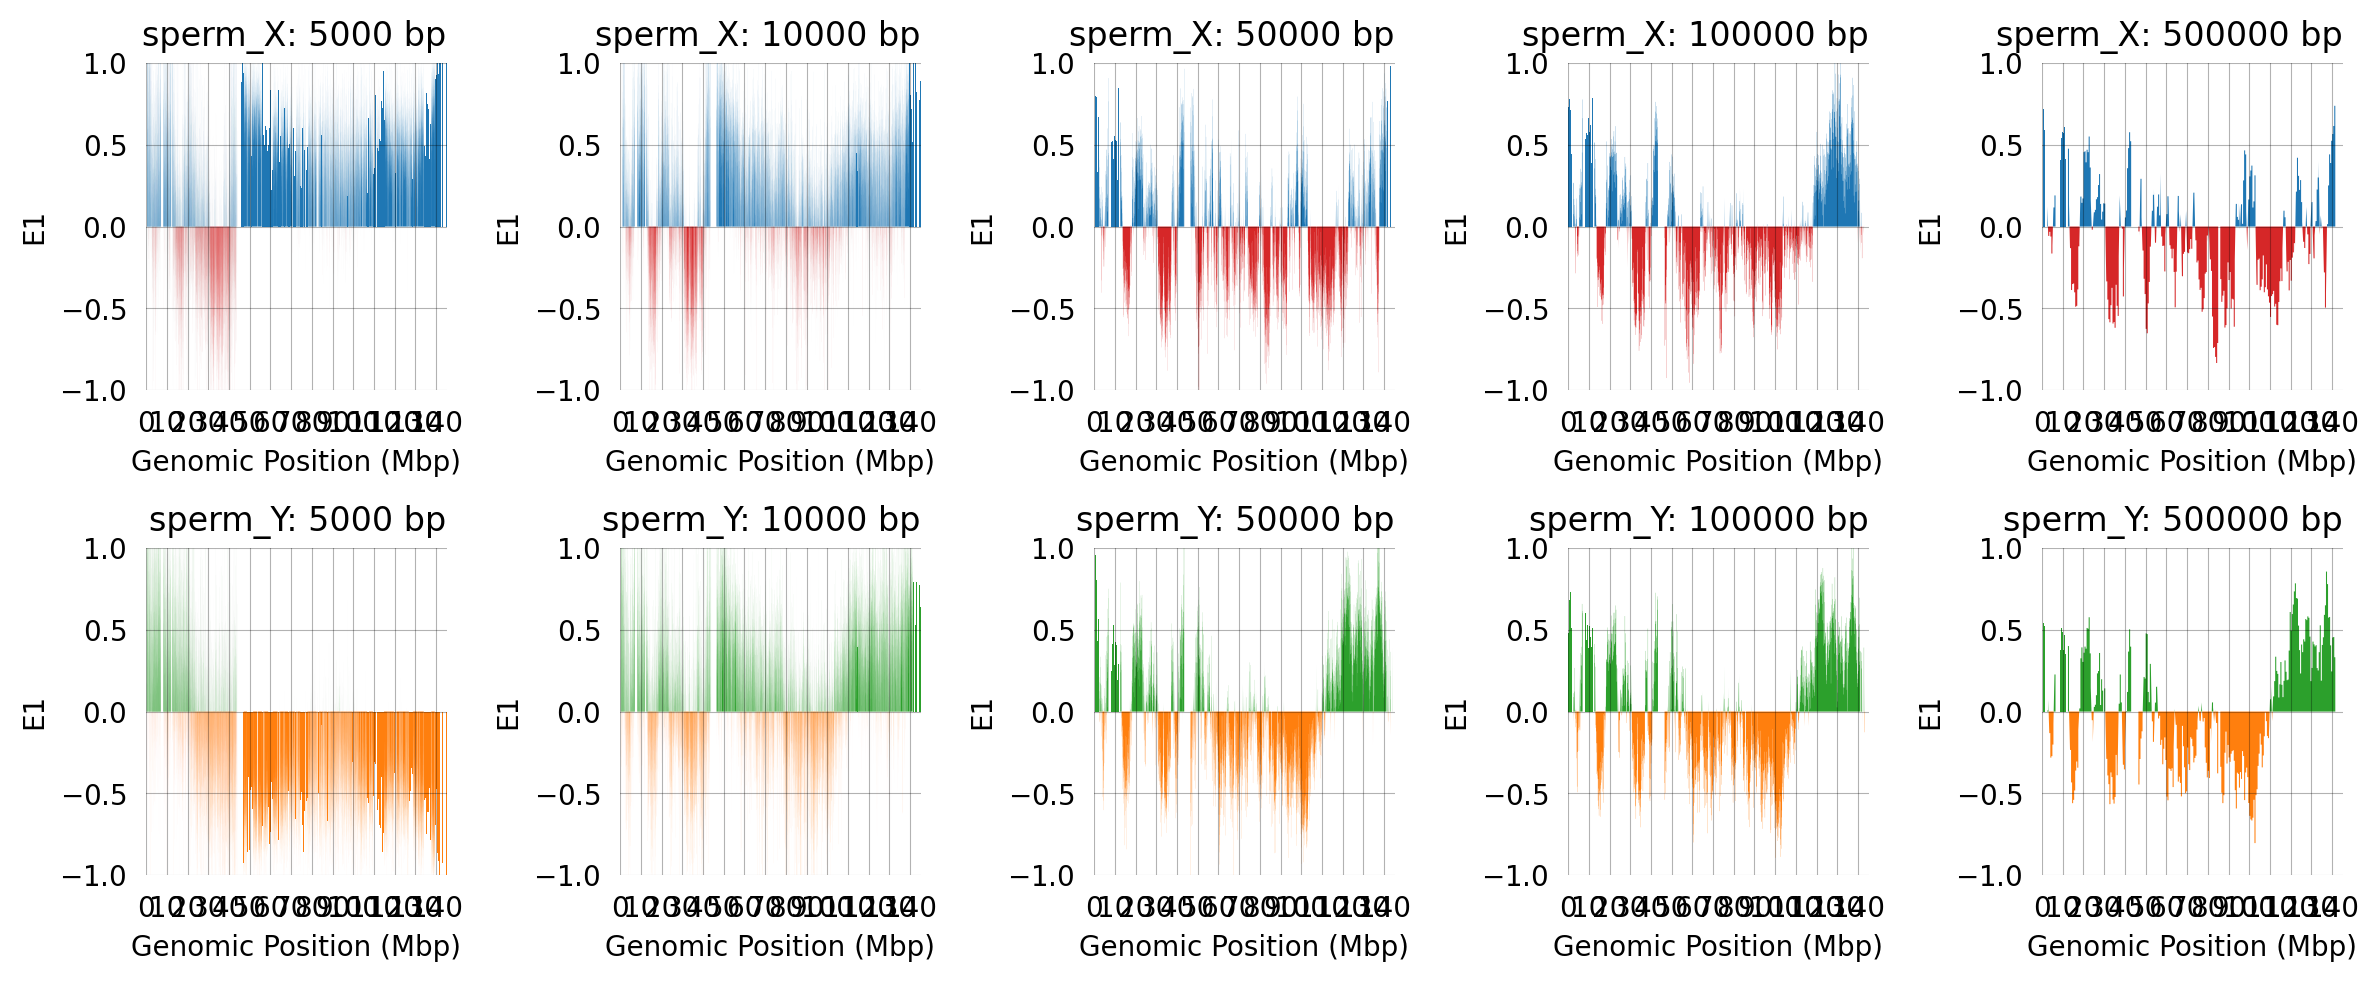

In [ ]:
[5000, 10000, 50000, 100000, 500000]
chrom = 'chr8'
eig = 'E1'

with vscode_theme(style='grid'):
    fig, axes = plt.subplots(2, len(resolutions), figsize=(12, 5))
    for i, tissue in enumerate(['sperm_X', 'sperm_Y']):
        for j, resolution in enumerate(resolutions):
            ax = axes[i, j]
            path = f"../steps/eigs/{tissue}_{chrom}.eigs.{resolution}.cis.vecs.tsv"
            df = pd.read_csv(path, sep="\t", header=0)
            x = df['start']
            y = df[eig]
            A_color = 'tab:red' if tissue == 'sperm_X' else 'tab:orange'
            B_color = 'tab:blue' if tissue == 'sperm_X' else 'tab:green'
            ax.fill_between(x, y, where = y<0, color=A_color, lw=1, ec='None', step='post', interpolate=True, label=f'A: {tissue}')
            ax.fill_between(x, y, where = y>0, color=B_color, lw=1, ec='None', step='post', interpolate=True, label=f'B: {tissue}') 
            ax.set_title(f'{tissue}: {resolution} bp')
            ax.set_ylabel(eig)
            ax.set_xlim(x.min(), x.max())
            ax.set_ylim(-1,1)
            ax.set_xlabel('Genomic Position (Mbp)')

            ticks = np.arange(0, x.max(), step=10_000_000)
            ax.set_xticks(ticks)
            ax.set_xticklabels([f'{int(t/1e6)}' for t in ticks])

    plt.tight_layout()

In [ ]:
def plot_xy_eigs(chrom, resolution, eig='E1', ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))

    for tissue in ['sperm_X', 'sperm_Y']:

        path = f"../steps/eigs/{tissue}_{chrom}.eigs.{resolution}.cis.vecs.tsv"
        df = pd.read_csv(path, sep="\t", header=0)
        x = df['start']
        y = df[eig]
        A_color = 'tab:red' if tissue == 'sperm_X' else 'tab:orange'
        B_color = 'tab:blue' if tissue == 'sperm_X' else 'tab:cyan'
        ax.fill_between(x, y, where = y<0, color=A_color, lw=1, ec='None', step='post', interpolate=True, alpha=0.5, label=f'A: {tissue}')
        ax.fill_between(x, y, where = y>0, color=B_color, lw=1, ec='None', step='post', interpolate=True, alpha=0.5, label=f'B: {tissue}') 
        ax.set_title(f'{chrom}, {resolution} bp')
        ax.set_ylabel(eig)
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(-1,1)
        ax.set_xlabel('Genomic Position (Mbp)')

        ticks = np.arange(0, x.max(), step=10_000_000)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{int(t/1e6)}' for t in ticks])

    return ax

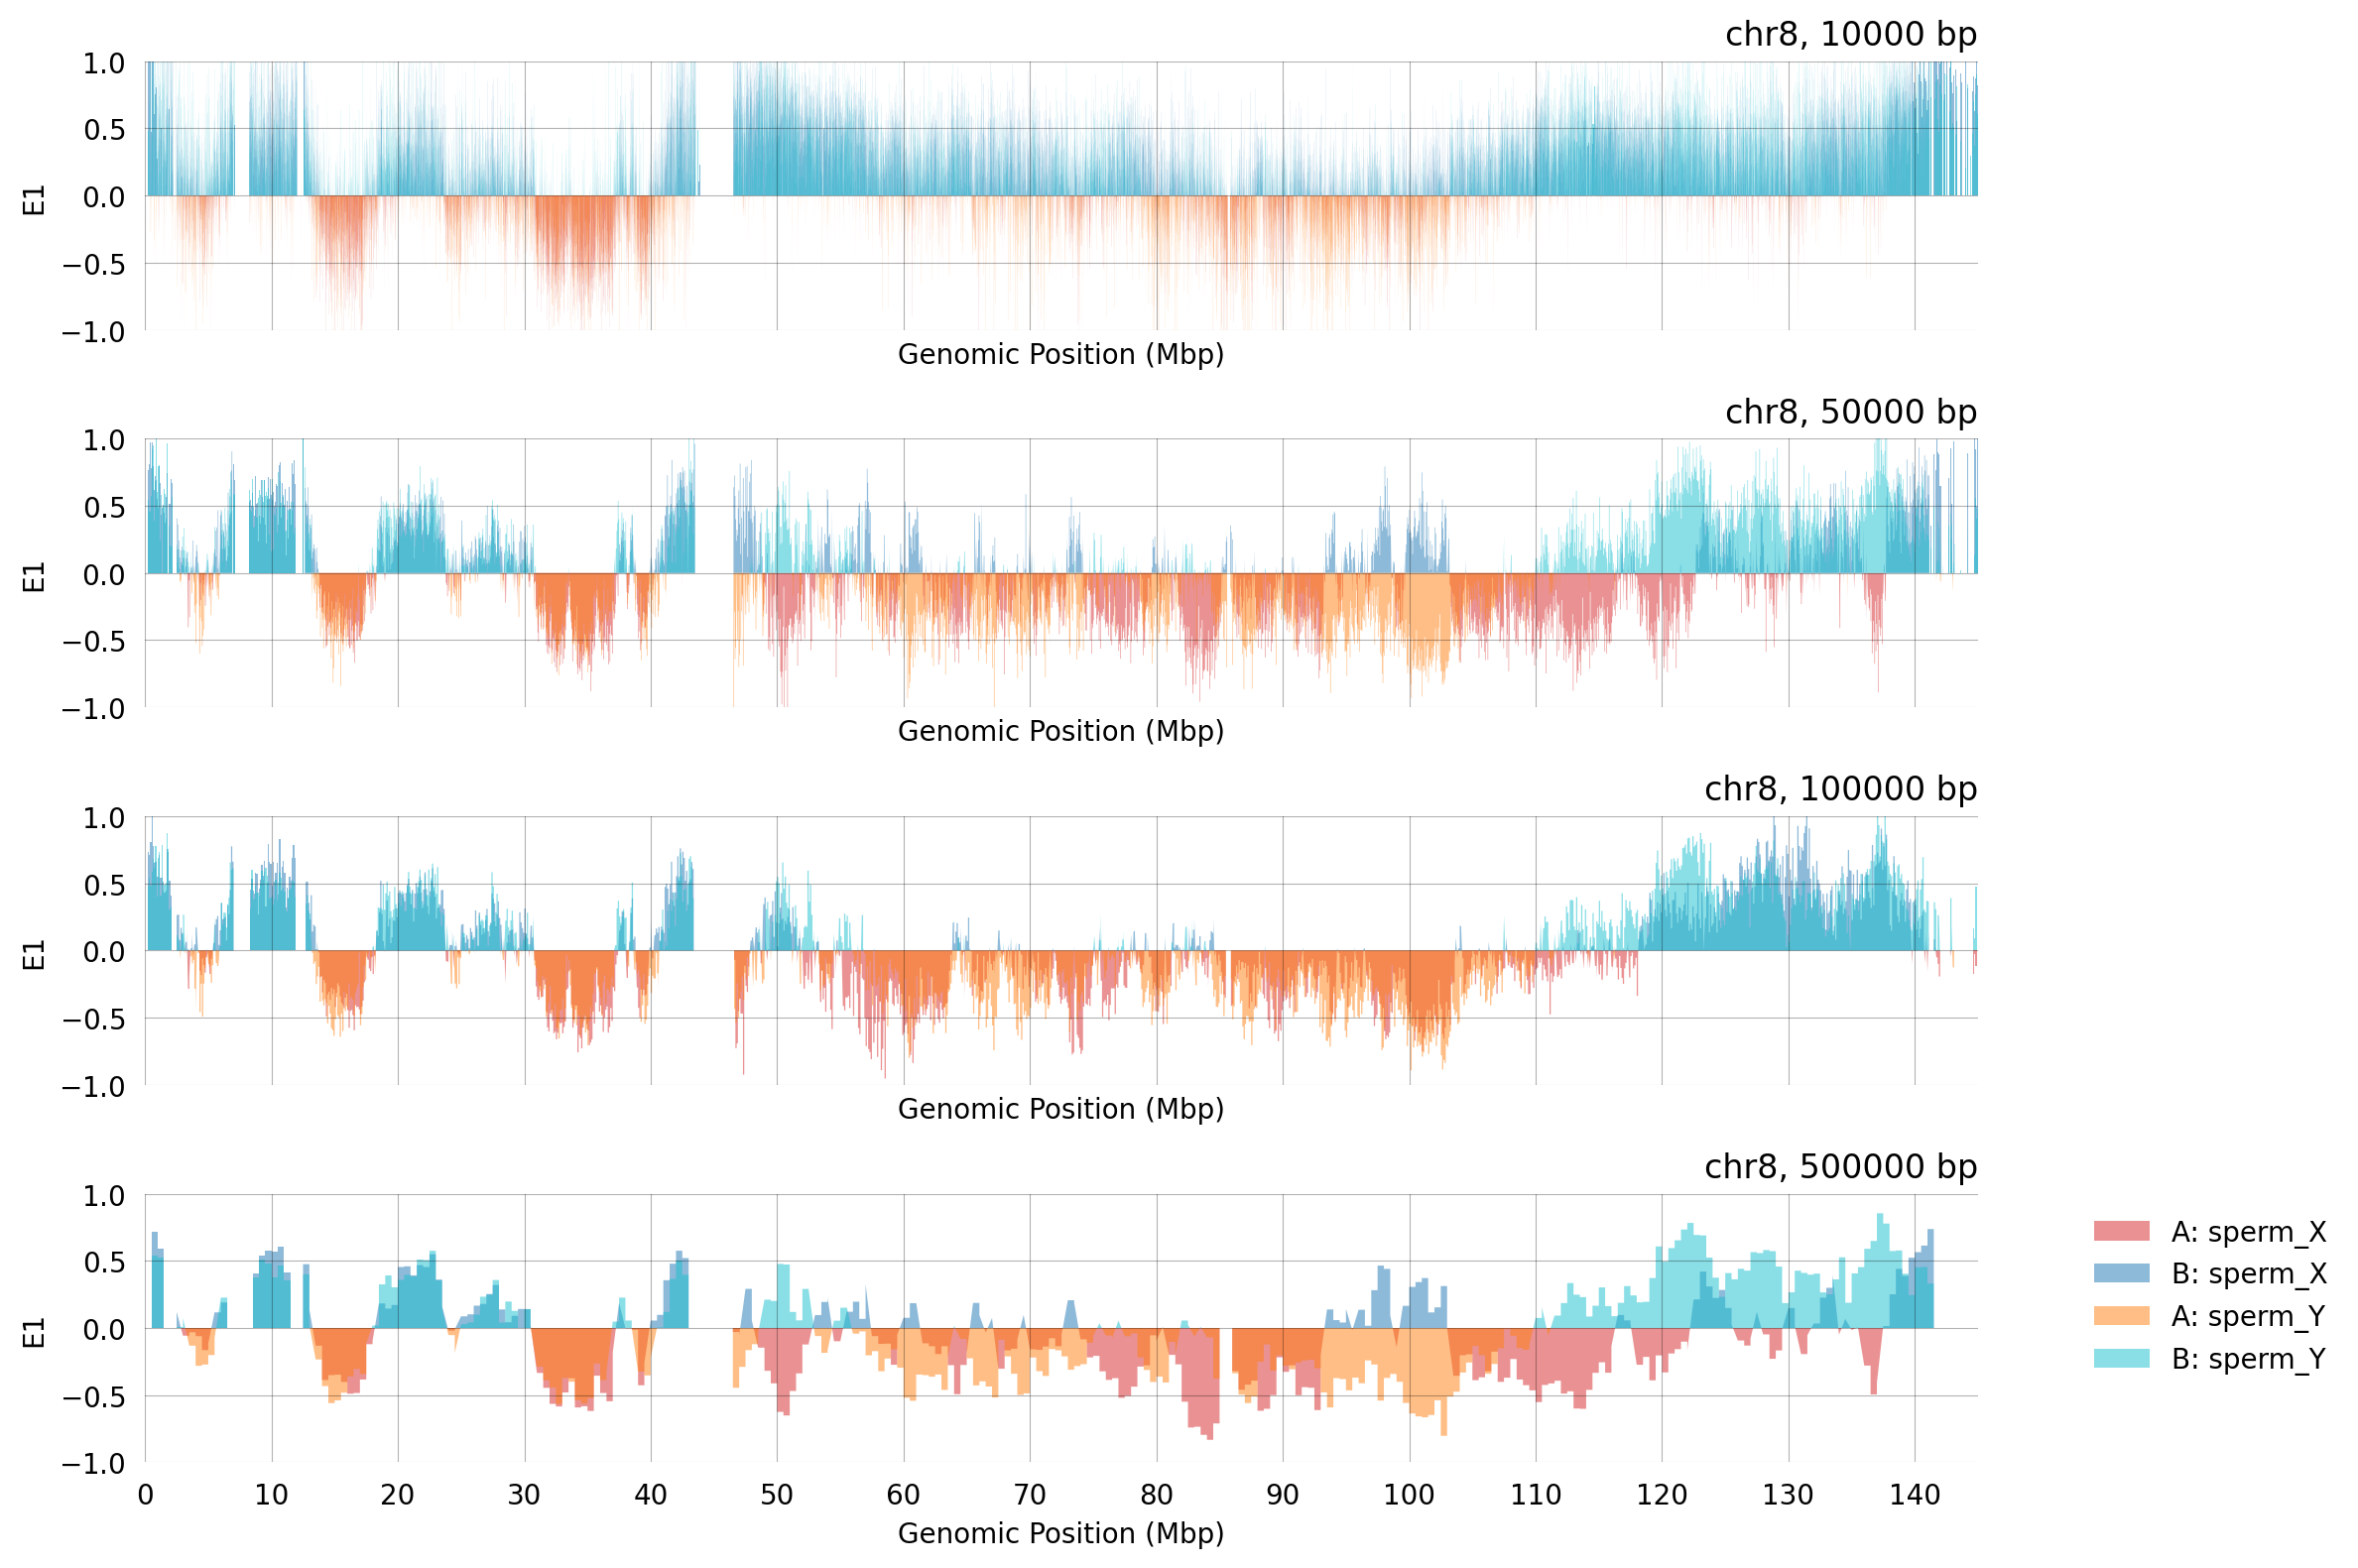

In [11]:
resolutions = [10000, 50000, 100000, 500000]
chrom = 'chr8'
eig = 'E1'

fig, axes = plt.subplots(len(resolutions), figsize=(12, 8), sharex=True)
for i, resolution in enumerate(resolutions):
    plot_xy_eigs(chrom, resolution, eig=eig, ax=axes[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## Compile a data frame with segment information for chromosome ideograms

In [12]:
resolution = 100000
df_list = []
tissues = 'sperm_X', 'sperm_Y'
for chrom in chromosomes[:22]:
    dfs = []
    for tissue in tissues:
        path = f"../steps/eigs/{tissue}_{chrom}.eigs.{resolution}.cis.vecs.tsv"
        df = pd.read_csv(path, sep="\t", header=0)
        df = df.loc[~df[eig].isnull()]
        df['comp'] = 'B'
        df.loc[df[eig] > 0, 'comp'] = 'A'
        dfs.append(df)

    df_X, df_Y = dfs
    df = df_X.merge(df_Y, on=['chrom', 'start'], how='inner', suffixes=(f'_{t}' for t in tissues))    

    df['end'] = df['start'] + resolution
    df['label'] = 'BB'
    df.loc[(df[f'{eig}_{tissues[0]}'] > 0) & (df[f'{eig}_{tissues[1]}'] > 0), 'label'] = 'AA'
    df.loc[(df[f'{eig}_{tissues[0]}'] > 0) & (df[f'{eig}_{tissues[1]}'] < 0), 'label'] = 'AB'
    df.loc[(df[f'{eig}_{tissues[0]}'] < 0) & (df[f'{eig}_{tissues[1]}'] > 0), 'label'] = 'BA'

    df_list.append(df[['chrom', 'start', 'end', 'label', f'E1_{tissues[0]}', f'E1_{tissues[1]}']])

segments_df = pd.concat(df_list)
segments_df.to_csv(f"../results/segments_{resolution}.tsv", sep="\t", index=False)
segments_df.head()

chrom    start      end label  E1_sperm_X  E1_sperm_Y
0  chr1  3800000  3900000    AA    0.107273    0.793105
1  chr1  3900000  4000000    AA    0.143871    0.680597
2  chr1  4000000  4100000    AA    0.050940    0.755038
3  chr1  4100000  4200000    AA    0.151969    0.757385
4  chr1  4200000  4300000    AA    0.102799    0.552499

## Gene lists

In [13]:
# # yaml format looks like this:
# """
# cool_genes:
#     description: "A list of cool genes"
#     genes: ['TP53', 'BRCA1', 'EGFR', 'VEGFA', 'MYC']
# target_genes:
#     description: "A list of other genes"
#     genes: ['AKT1', 'PIK3CA', 'PTEN', 'TP53', 'BRCA1']
# """

# gene_lists = GeneListCollection('gene_lists.yaml')
# sample_genes = gene_lists.get('cool_genes')
# # OR
# sample_genes = glist(['AKT1', 'PIK3CA', 'PTEN', 'TP53', 'BRCA1'])
# OR
gene_lists = GeneListCollection(google_sheet='1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk')
sample_genes = gene_lists.get('cDEG')


In [14]:
segments_df.label.value_counts()

label
AA    10822
BB    10541
BA     2160
AB     2067
Name: count, dtype: int64

## Get genes by GO terms

(takes a long time to run the first time because it downloads GO databases)

In [ ]:
from geneinfo.ontology import get_terms_for_go_regex, get_genes_for_go_terms

terms = get_terms_for_go_regex(r'kinesin|dynein|tubulin', add_children=False)
show_go_dag_for_terms(terms, add_relationships=True)

In [ ]:
genes = get_genes_for_go_terms(terms)
glist(genes)

## Ideograms

<Figure size 640x480 with 0 Axes>

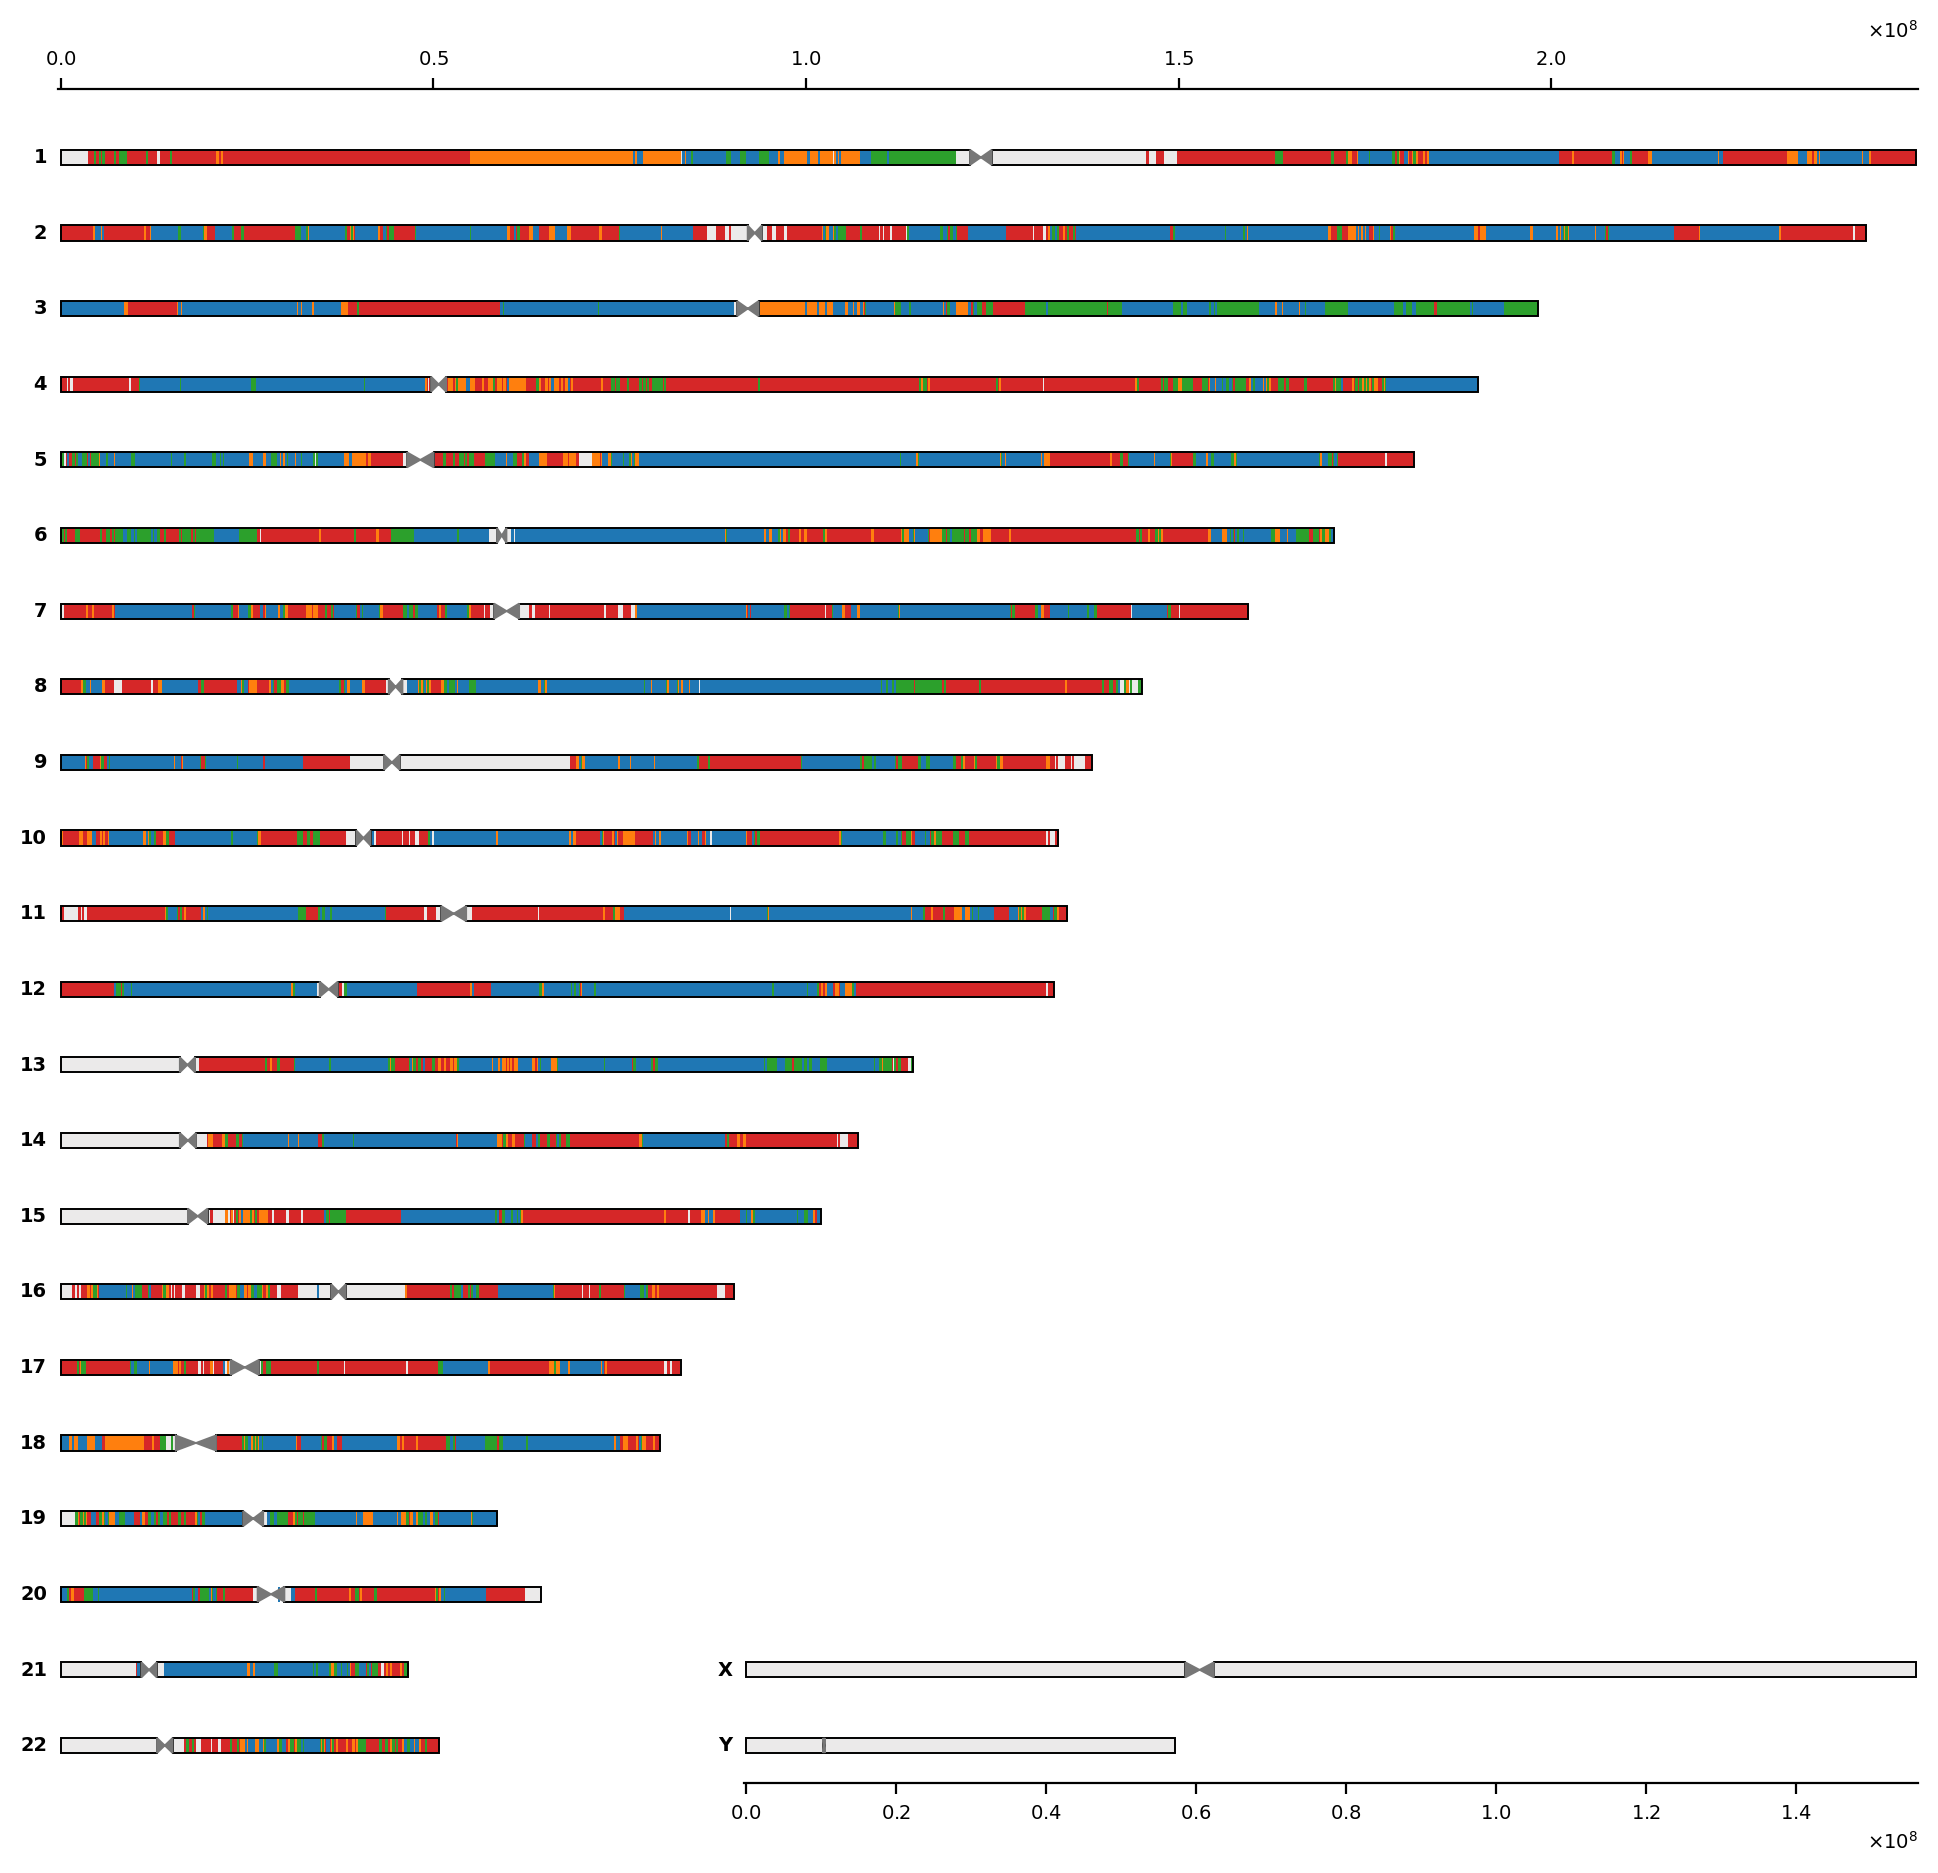

In [15]:
with vscode_theme(style='ticks'):
    g = GenomeIdeogram(assembly='hg38') 
    g.draw_chromosomes()
    colors = dict(AA='tab:red', AB='tab:orange', BA='tab:green', BB='tab:blue')
    for label, color in colors.items():
        segments = [(tup.chrom, tup.start, tup.end) for tup in segments_df.itertuples(index=False) if tup.label == label]
        g.add_segments(segments, facecolor=color)

<Figure size 640x480 with 0 Axes>

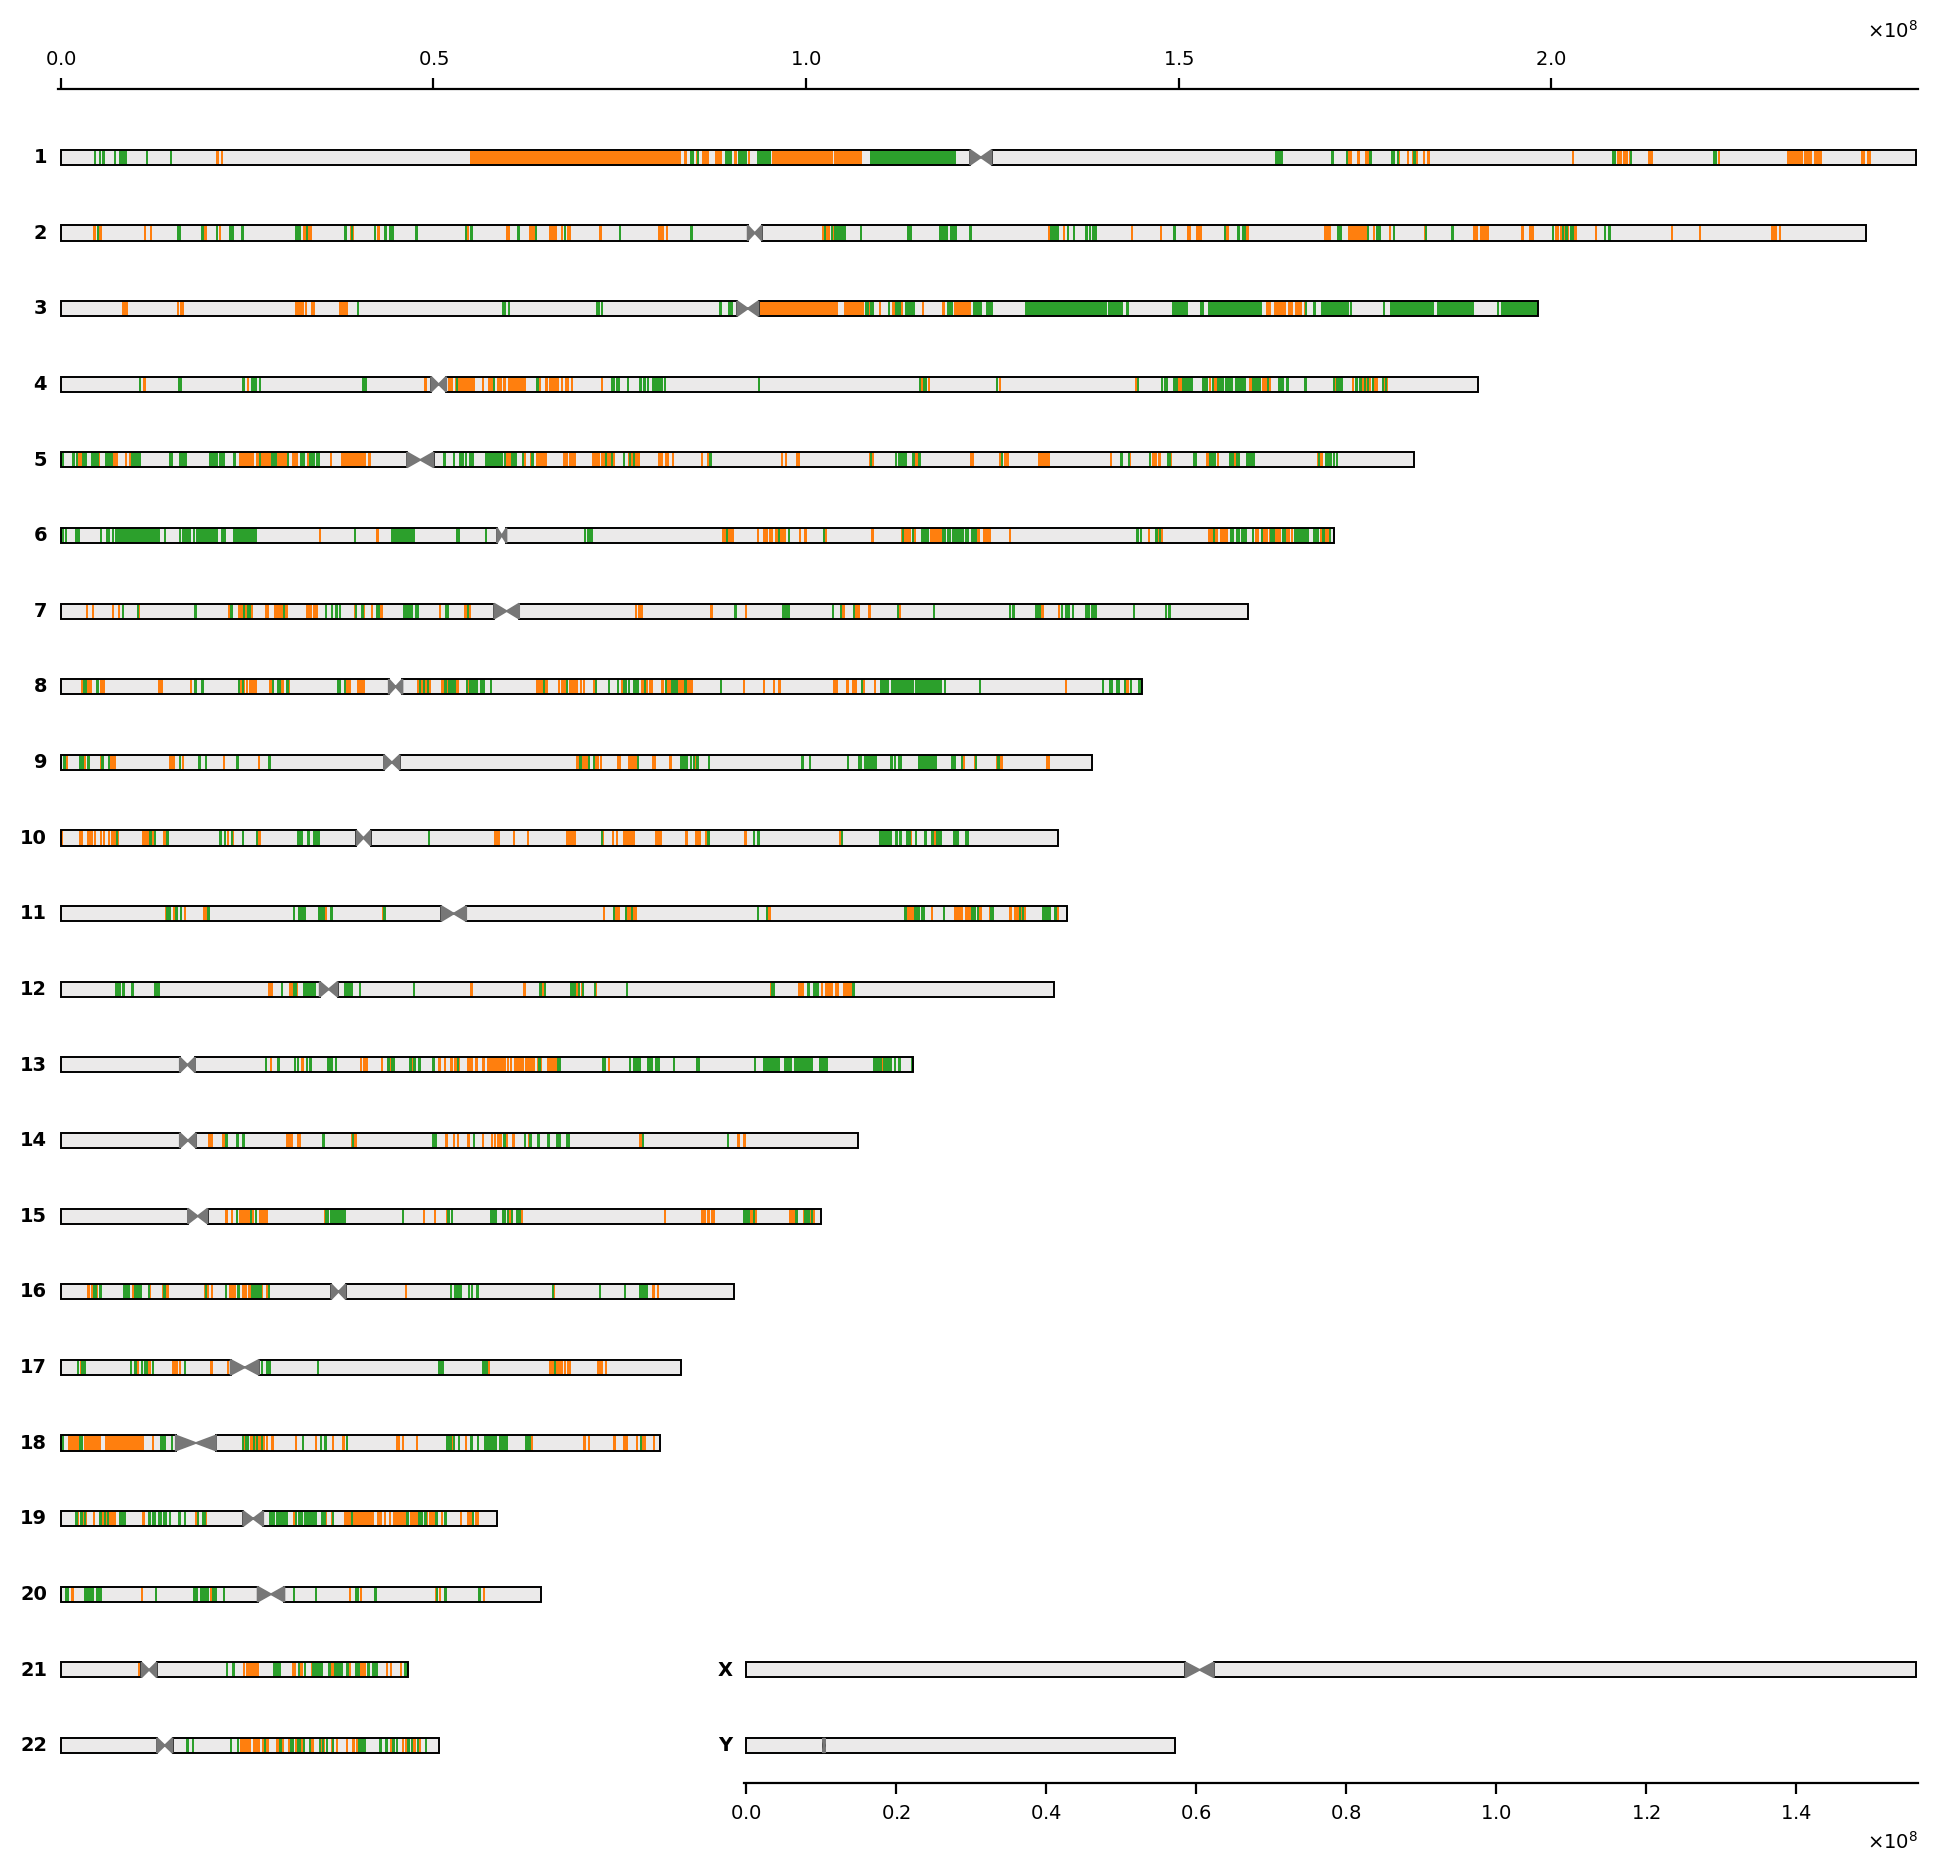

In [16]:
with vscode_theme(style='ticks'):
    g = GenomeIdeogram(assembly='hg38') 
    g.draw_chromosomes()
    colors = dict(AA='tab:red', AB='tab:orange', BA='tab:green', BB='tab:blue')
    for label, color in colors.items():
        if label in ['AA', 'BB']: 
            continue
        segments = [(tup.chrom, tup.start, tup.end) for tup in segments_df.itertuples(index=False) if tup.label == label]
        g.add_segments(segments, facecolor=color)

In [17]:
non_concordant = interval_collapse(segments_df.loc[segments_df.label.isin(['AB', 'BA'])])
concordant = interval_collapse(segments_df.loc[segments_df.label.isin(['AA', 'BB'])])

In [19]:
from geneinfo.coords import gene_coords_region

all_genes_file_name = "../results/all_genes.h5"
if os.path.exists(all_genes_file_name):
    all_genes_df = pd.read_hdf(all_genes_file_name, key='df')
else:
    records = []
    for chrom in chromosomes:
        for gene_name, chrom, start, end, *_ in gene_coords_region(chrom, assembly=assembly):
            records.append([gene_name, chrom, start, end])
    all_genes_df = pd.DataFrame.from_records(records, columns=['gene_name', 'chrom', 'start', 'end'])
    all_genes_df.to_hdf(all_genes_file_name, key='df', mode='w')

In [20]:
import pyranges as pr

def get_overlapping_rows(df1, df2):
    """Use pyranges, return original df1 rows with all columns."""
    df1_indexed = df1.reset_index(names='_orig_idx')
    gr1 = pr.PyRanges(df1_indexed.rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'}))
    gr2 = pr.PyRanges(df2.rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'}))
    overlaps = gr1.overlap(gr2)
    if overlaps.empty:
        return df1.iloc[:0]
    matching_indices = overlaps.df['_orig_idx'].unique()
    return df1.loc[matching_indices]

Get all genes part of reginos larger than 500kb with different compartment status in X and Y sperm Hi-C:

In [21]:
all_genes_df = pd.read_hdf(f"../results/all_genes.h5")
get_overlapping_rows(all_genes_df, non_concordant.loc[lambda df: df.end - df.start > 500000])

gene_name  chrom     start       end
1340   LOC105378740   chr1  55783660  55854927
1341      LINC01753   chr1  55915608  55944963
1342      LINC01755   chr1  55945086  55950119
1343   LOC105378737   chr1  55961068  56059159
1344   LOC105378741   chr1  56050978  56125489
...             ...    ...       ...       ...
40479        HMGXB4  chr22  35241535  35295807
40480          TOM1  chr22  35299274  35347973
40481       MIR3909  chr22  35335639  35335758
40482       MIR6069  chr22  35336720  35336799
40483         HMOX1  chr22  35381095  35394207

[1895 rows x 4 columns]

In [22]:
chroms = iter(chromosomes)

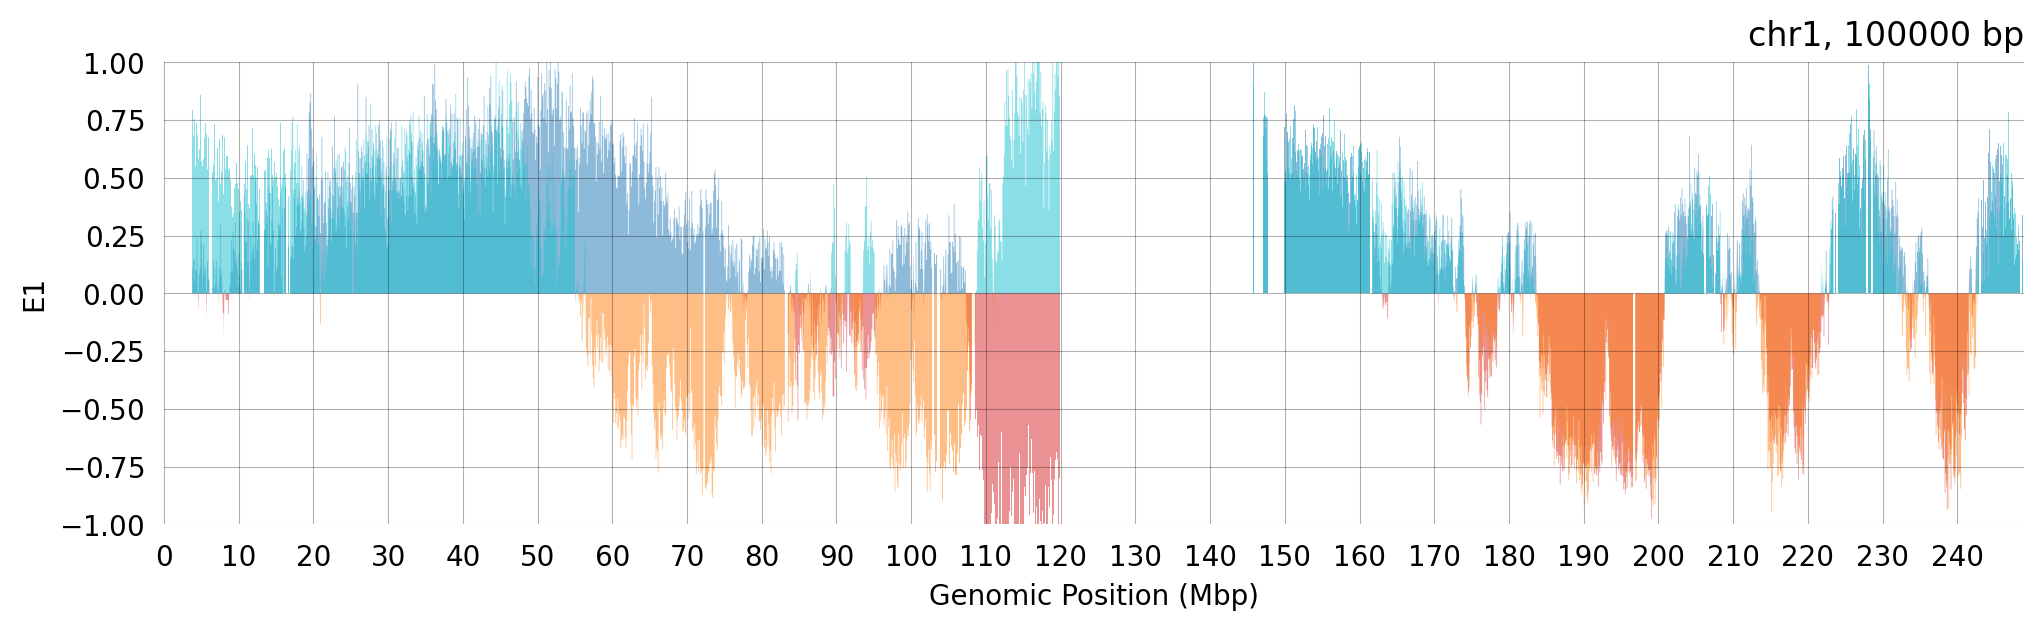

In [23]:
plot_xy_eigs(next(chroms), resolution=100000);

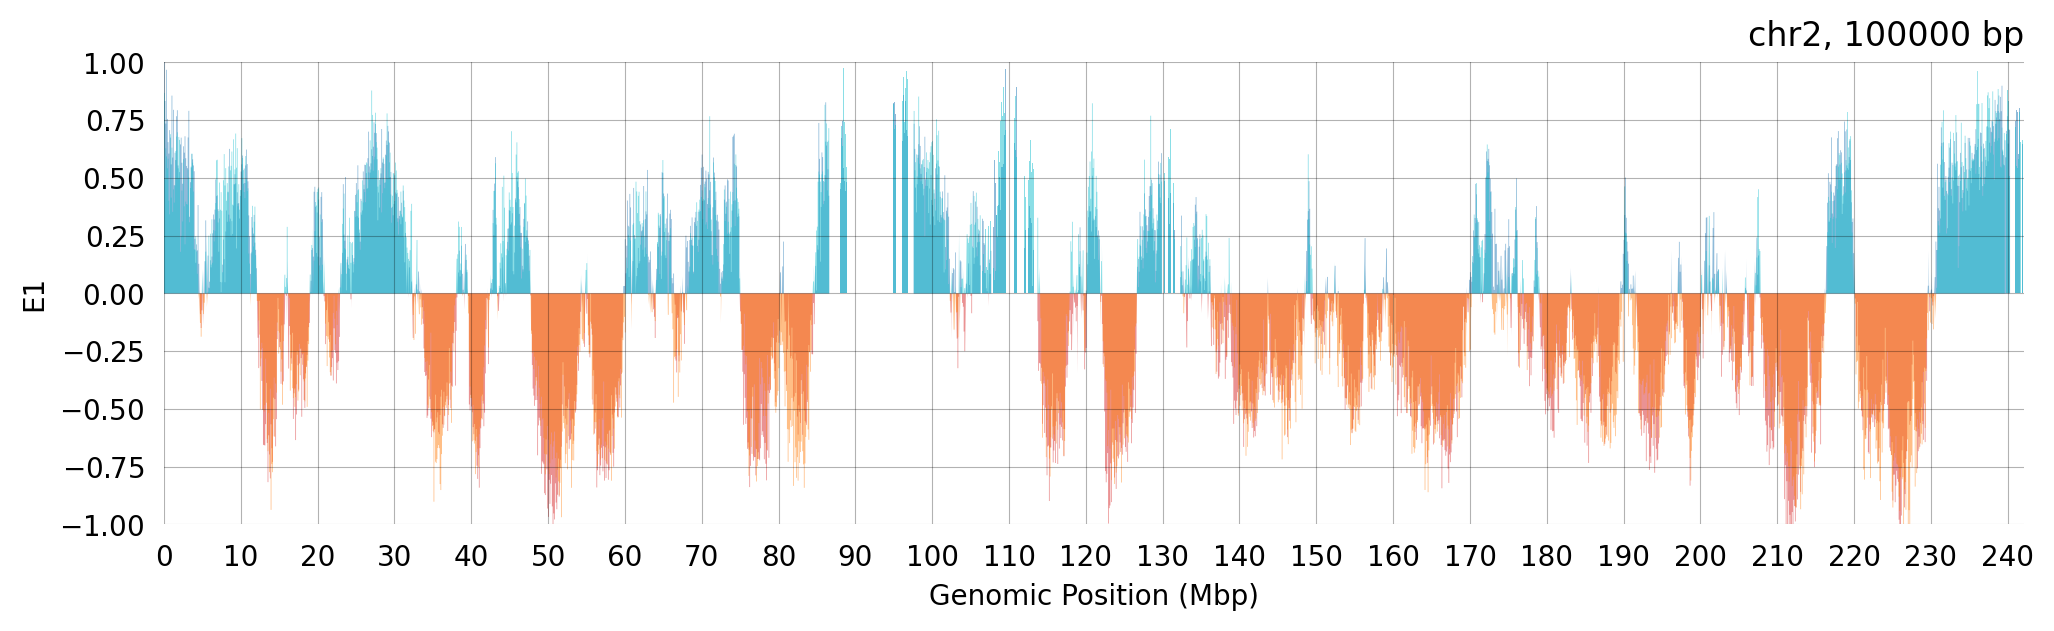

In [24]:
plot_xy_eigs(next(chroms), resolution=100000);

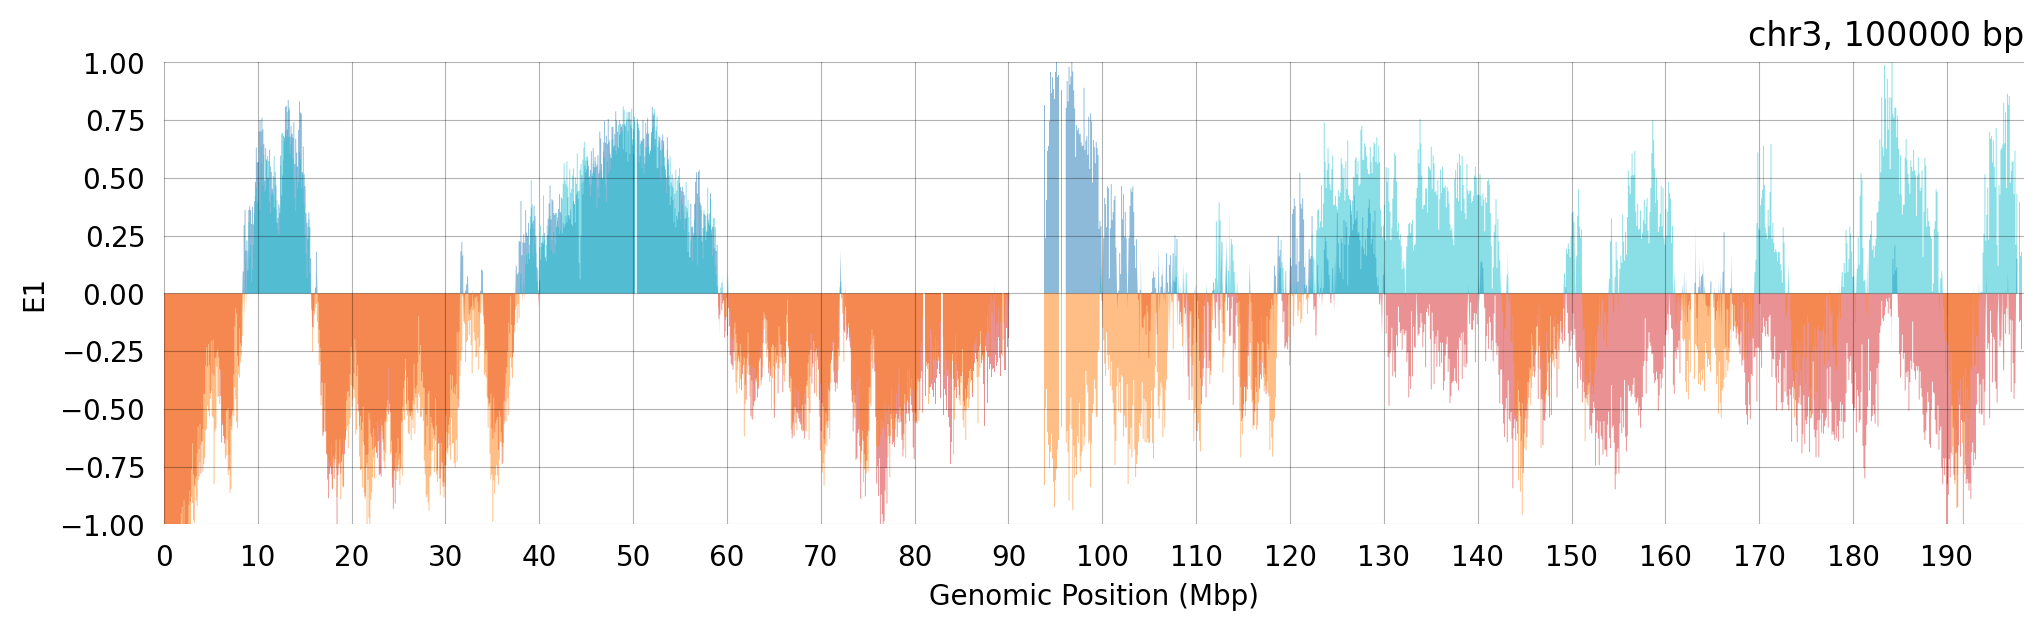

In [25]:
plot_xy_eigs(next(chroms), resolution=100000);

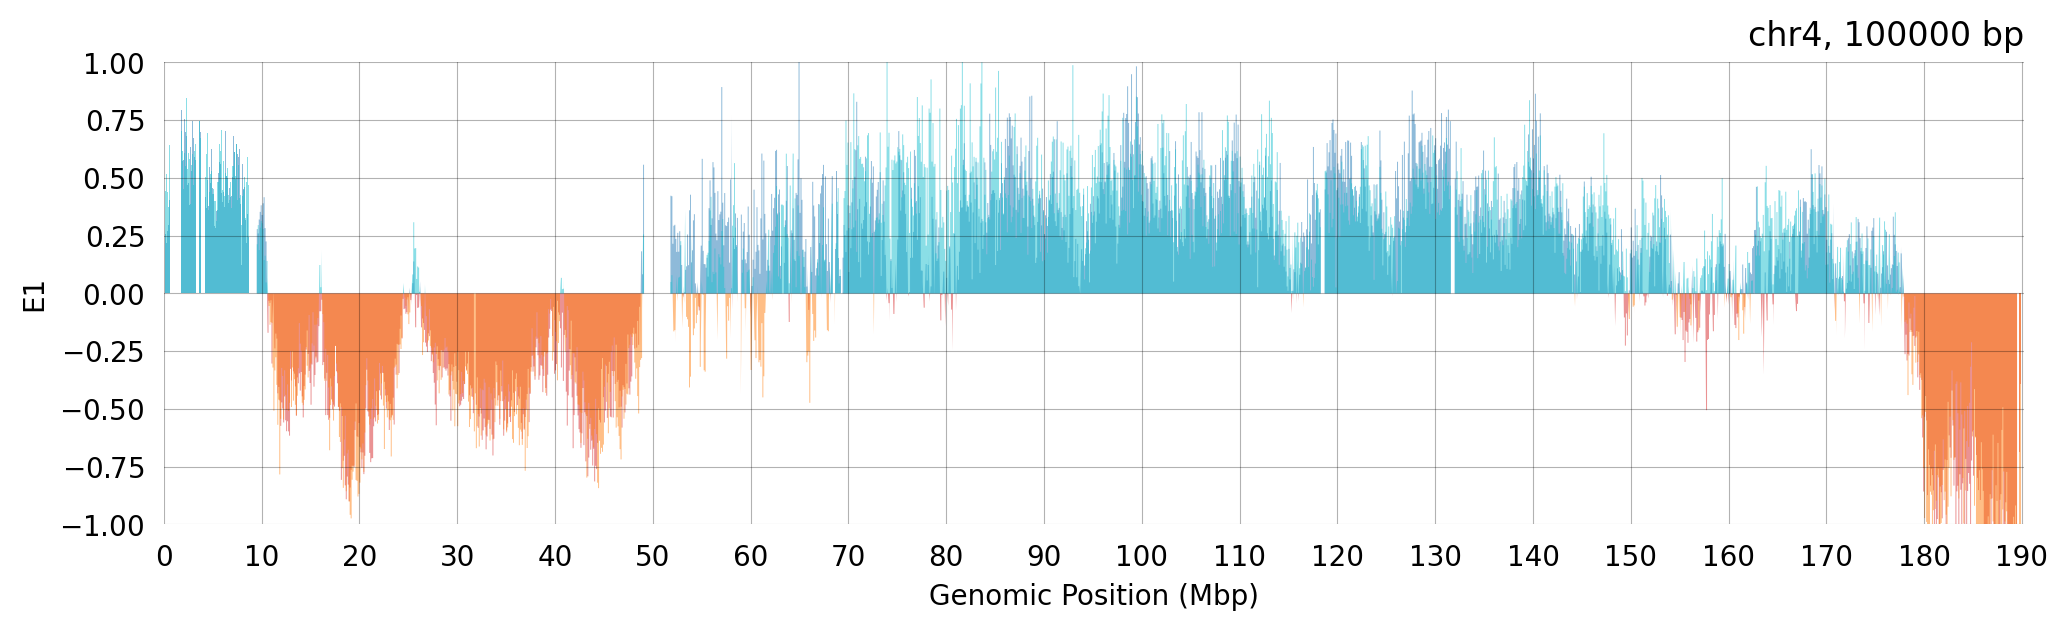

In [26]:
plot_xy_eigs(next(chroms), resolution=100000);

In [27]:
plot_xy_eigs(next(chroms), resolution=100000);

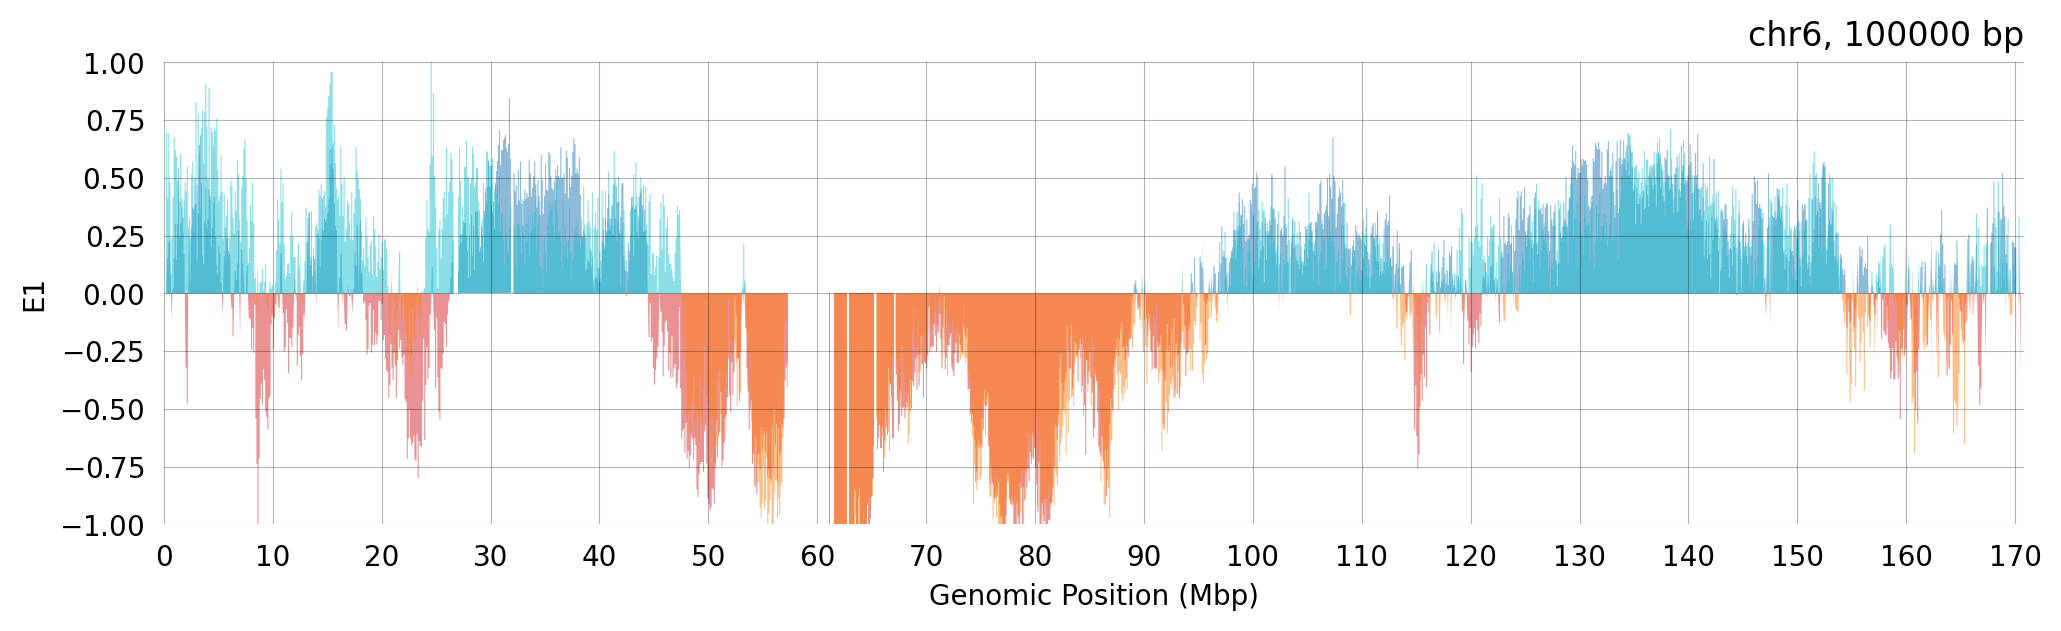

In [28]:
plot_xy_eigs(next(chroms), resolution=100000);

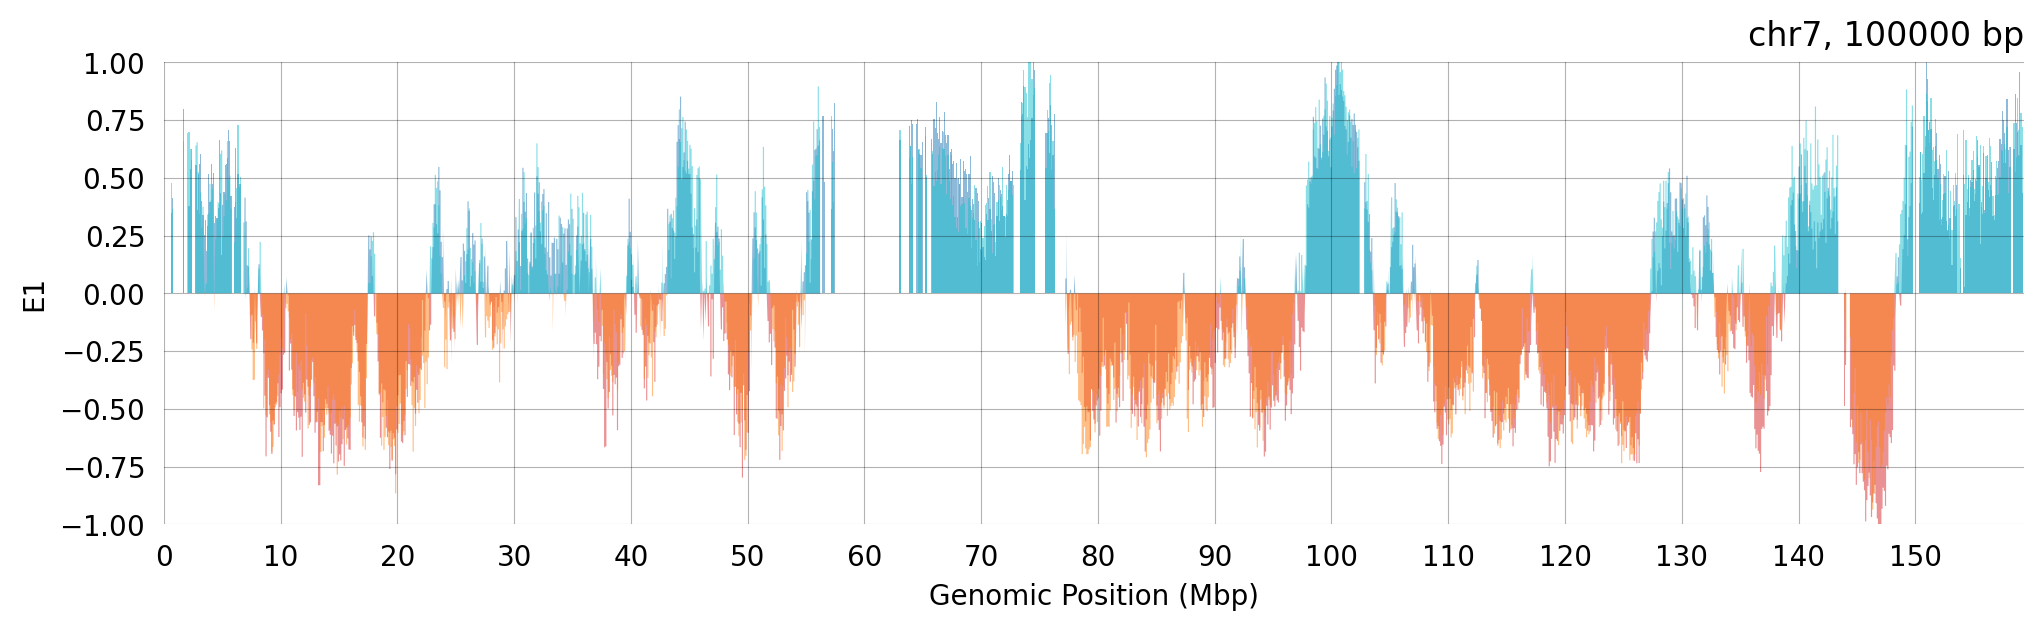

In [29]:
plot_xy_eigs(next(chroms), resolution=100000);

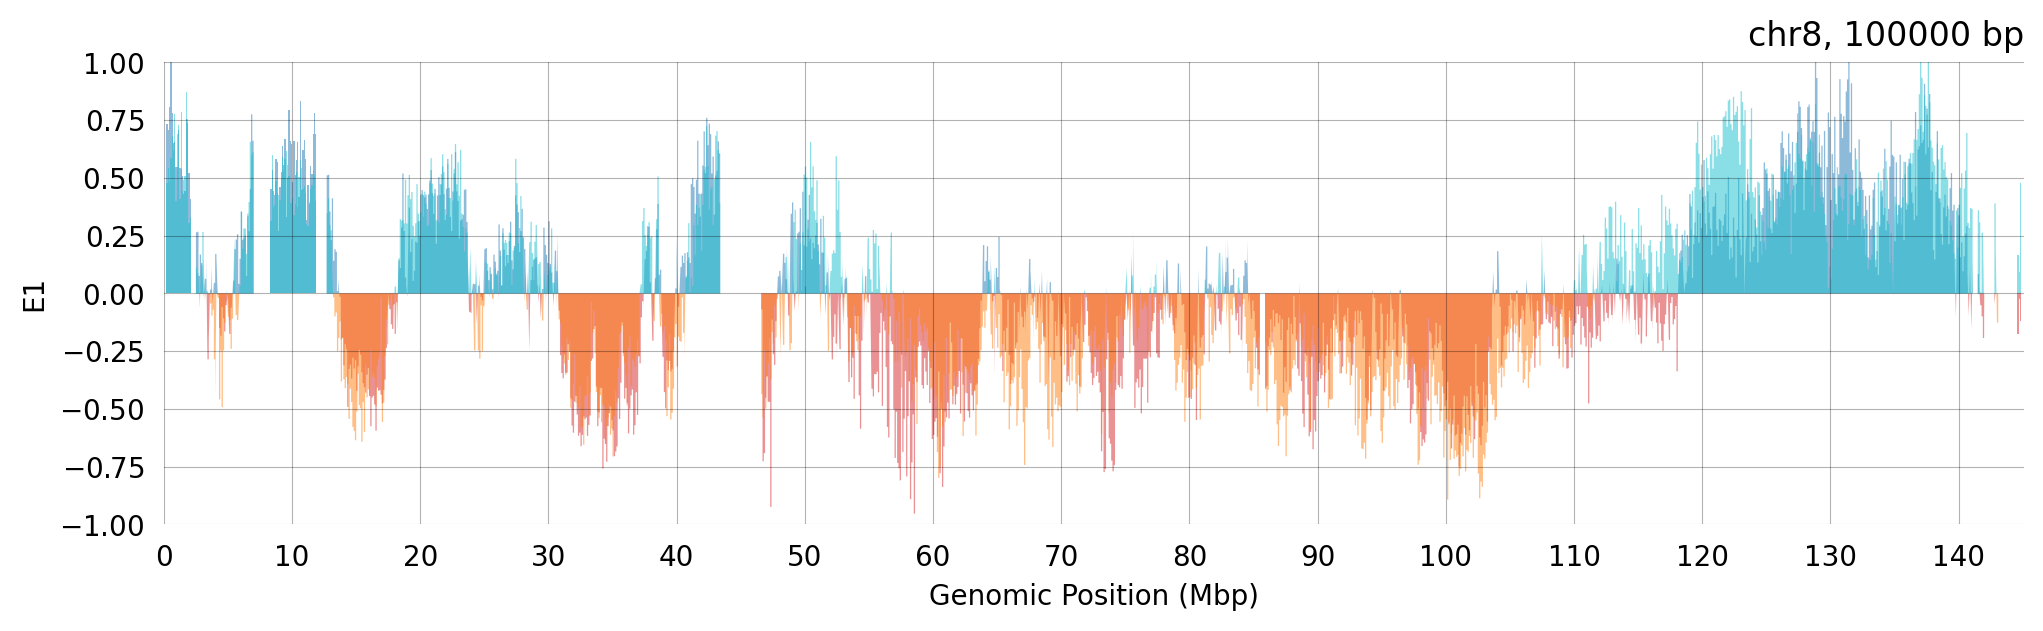

In [30]:
plot_xy_eigs(next(chroms), resolution=100000);

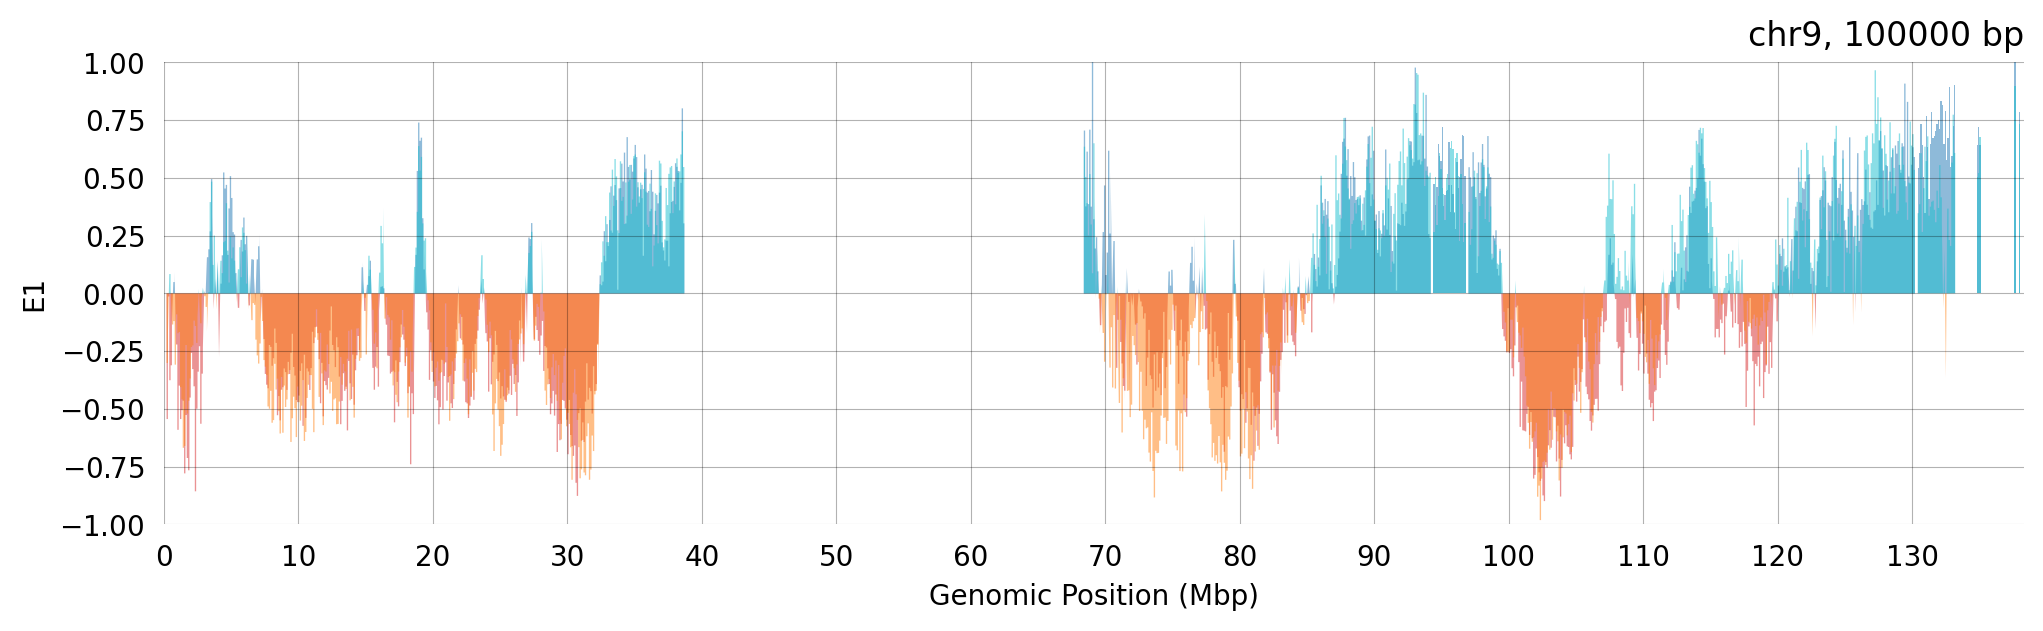

In [31]:
plot_xy_eigs(next(chroms), resolution=100000);

In [32]:
plot_xy_eigs(next(chroms), resolution=100000);

In [33]:
plot_xy_eigs(next(chroms), resolution=100000);

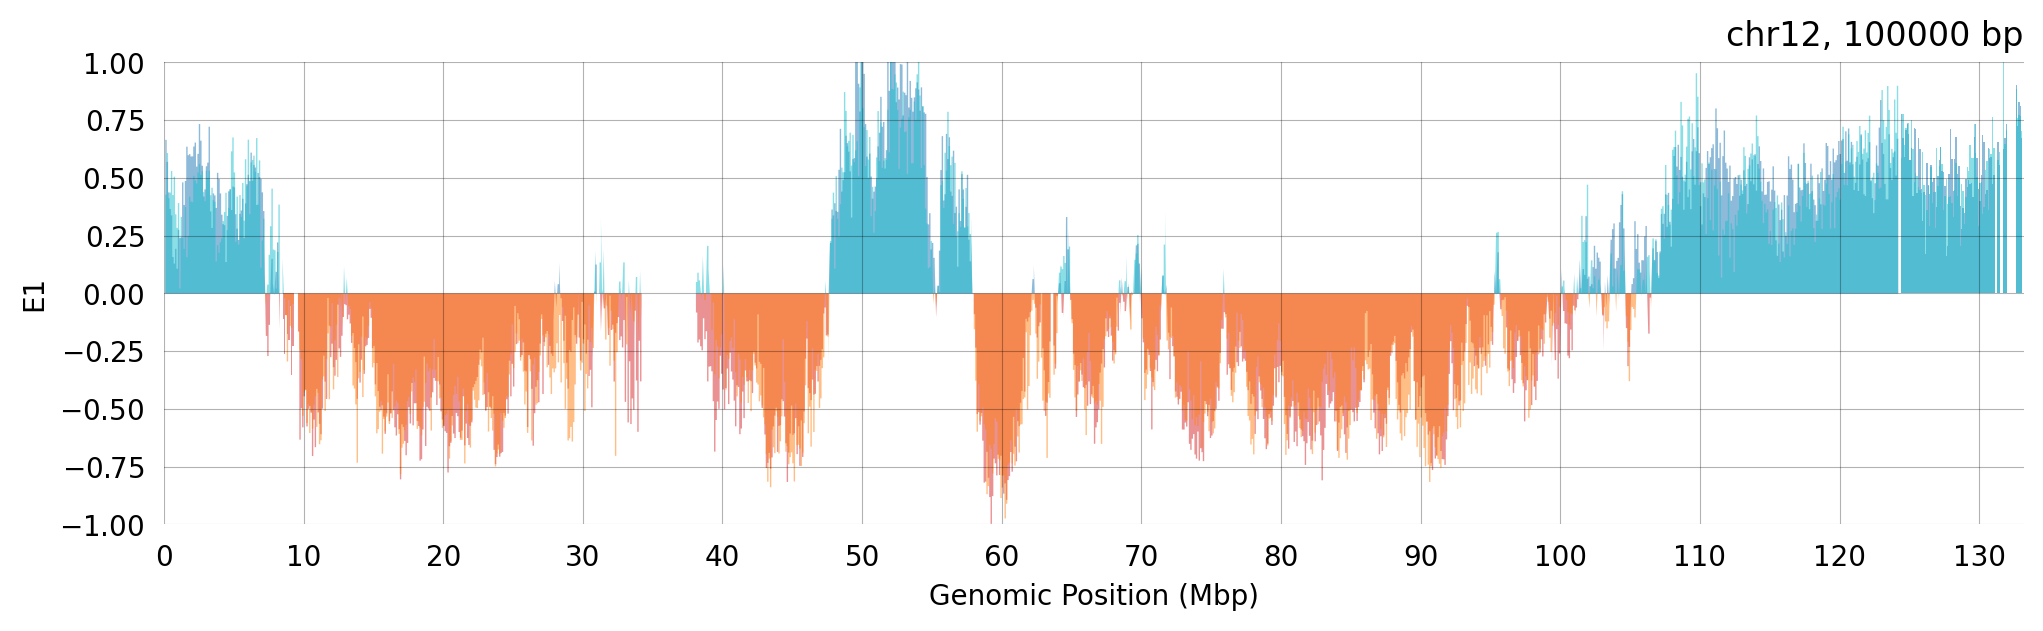

In [34]:
plot_xy_eigs(next(chroms), resolution=100000);

In [35]:
plot_xy_eigs(next(chroms), resolution=100000);

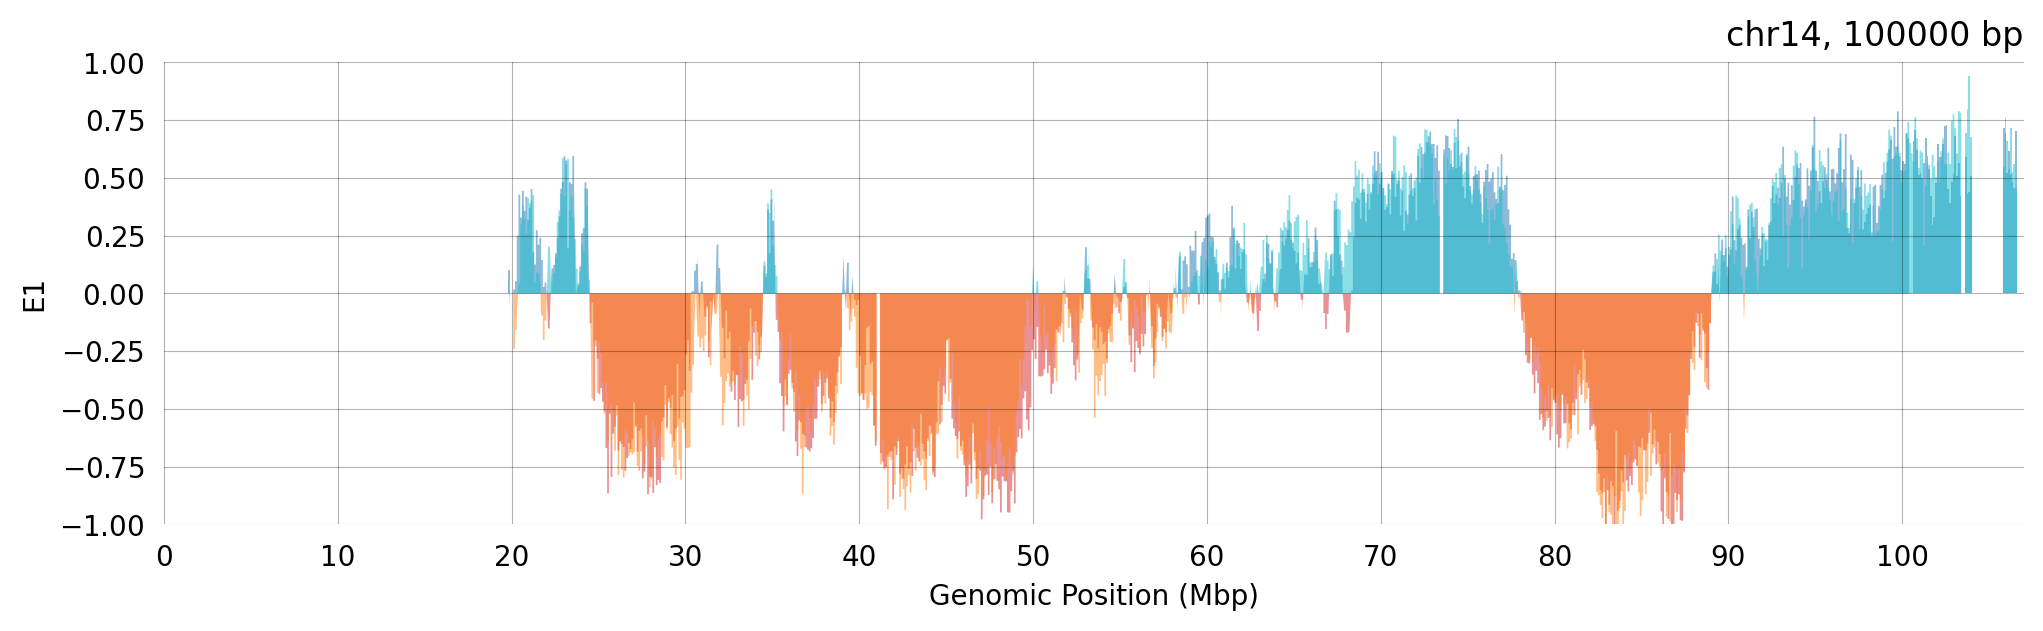

In [36]:
plot_xy_eigs(next(chroms), resolution=100000);

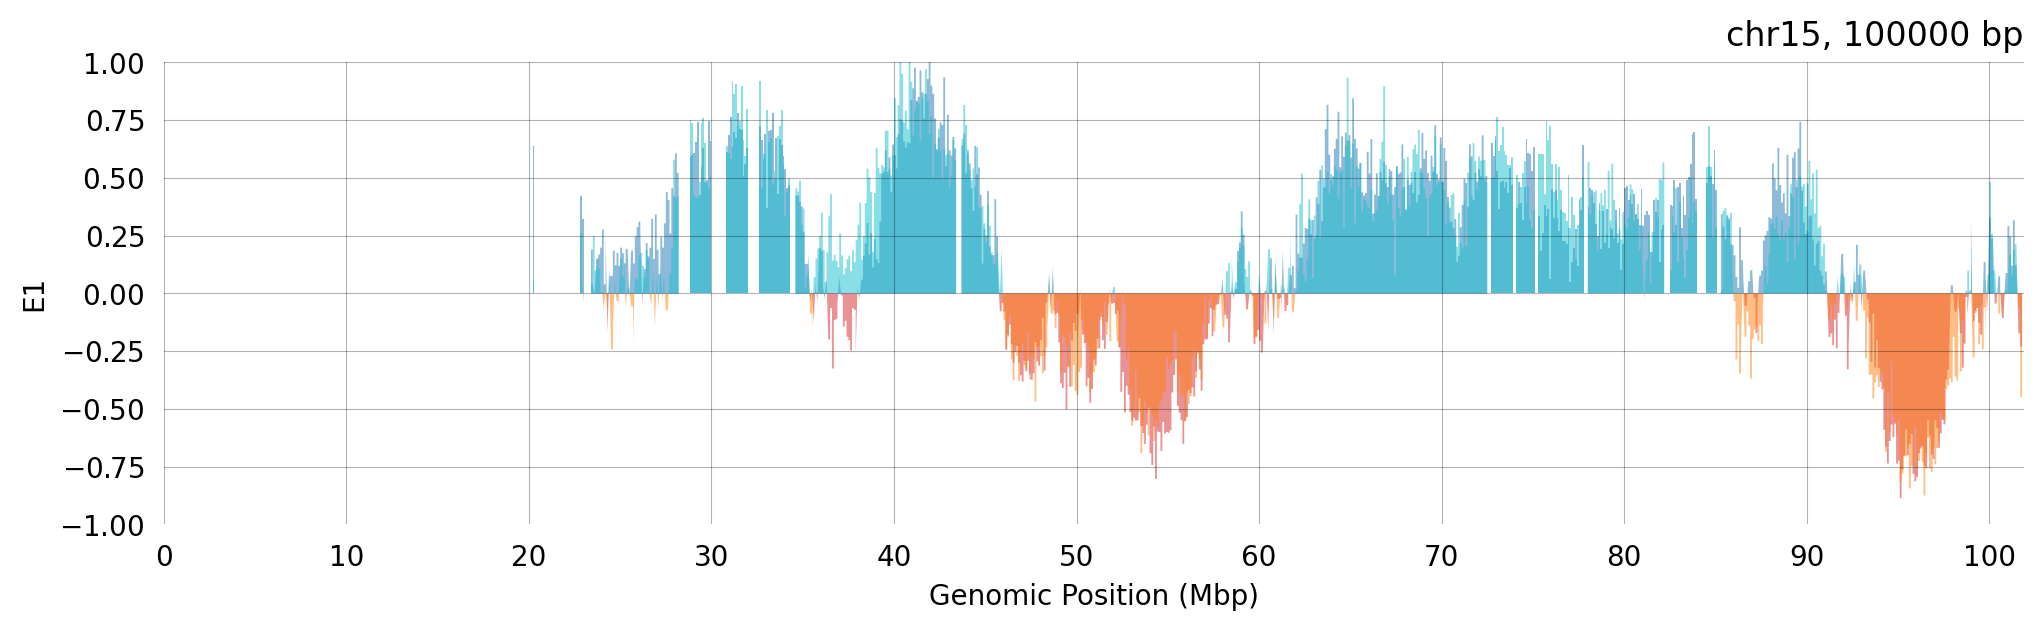

In [37]:
plot_xy_eigs(next(chroms), resolution=100000);

In [38]:
plot_xy_eigs(next(chroms), resolution=100000);

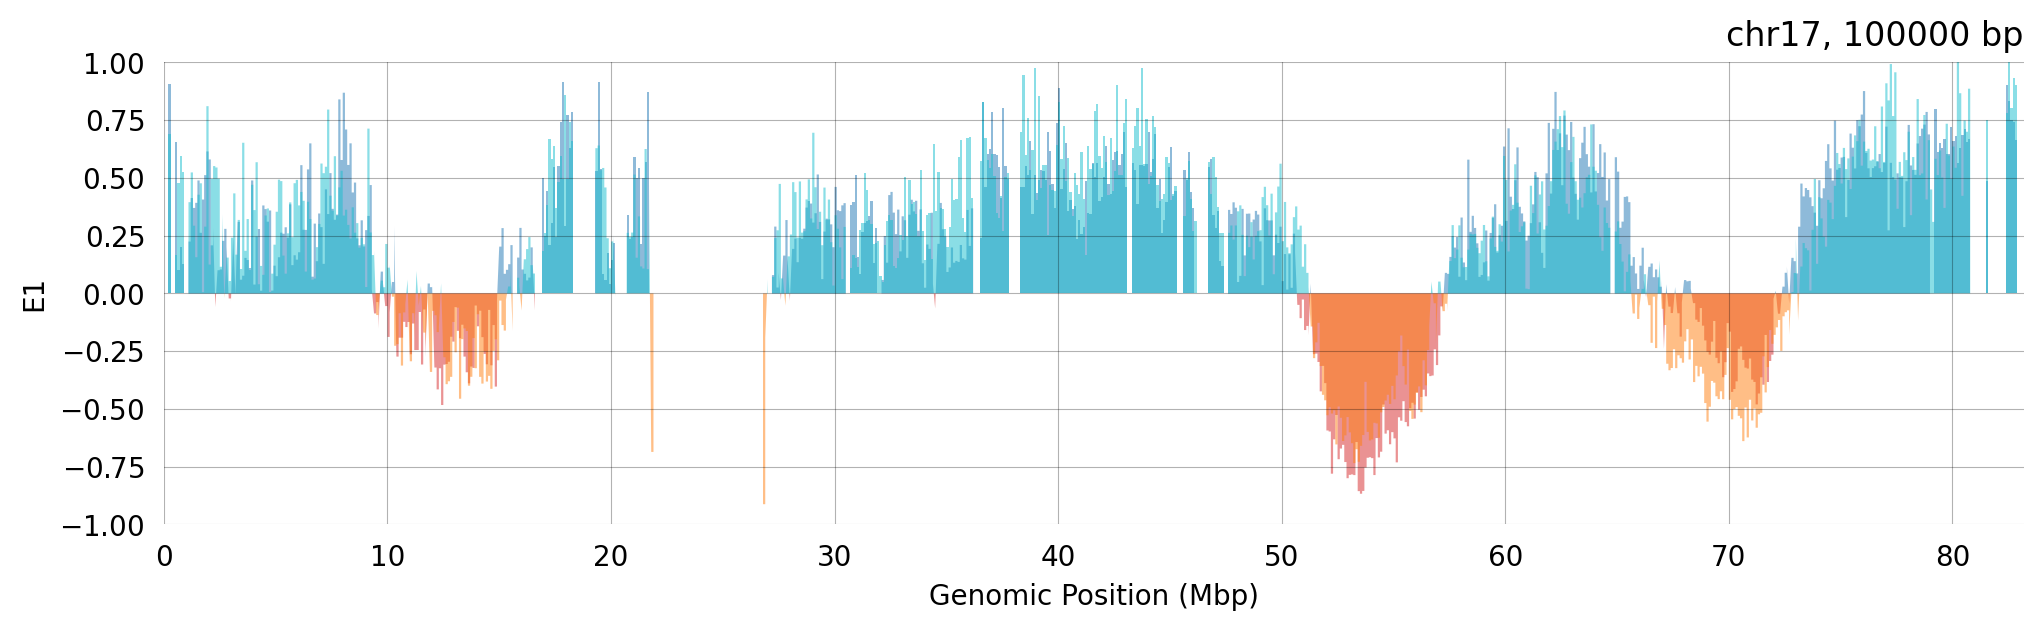

In [39]:
plot_xy_eigs(next(chroms), resolution=100000);

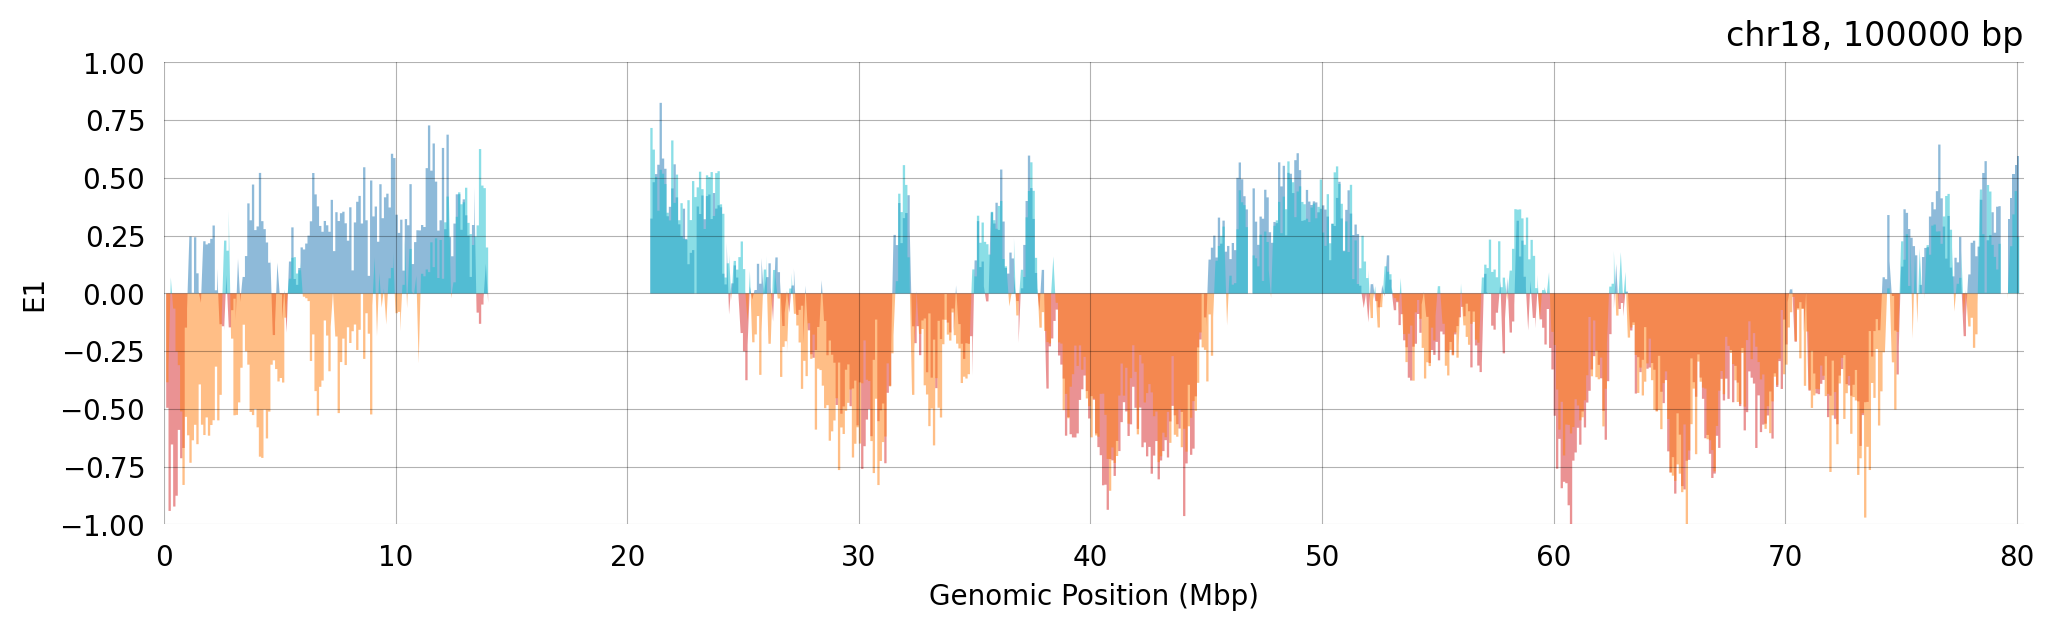

In [40]:
plot_xy_eigs(next(chroms), resolution=100000);

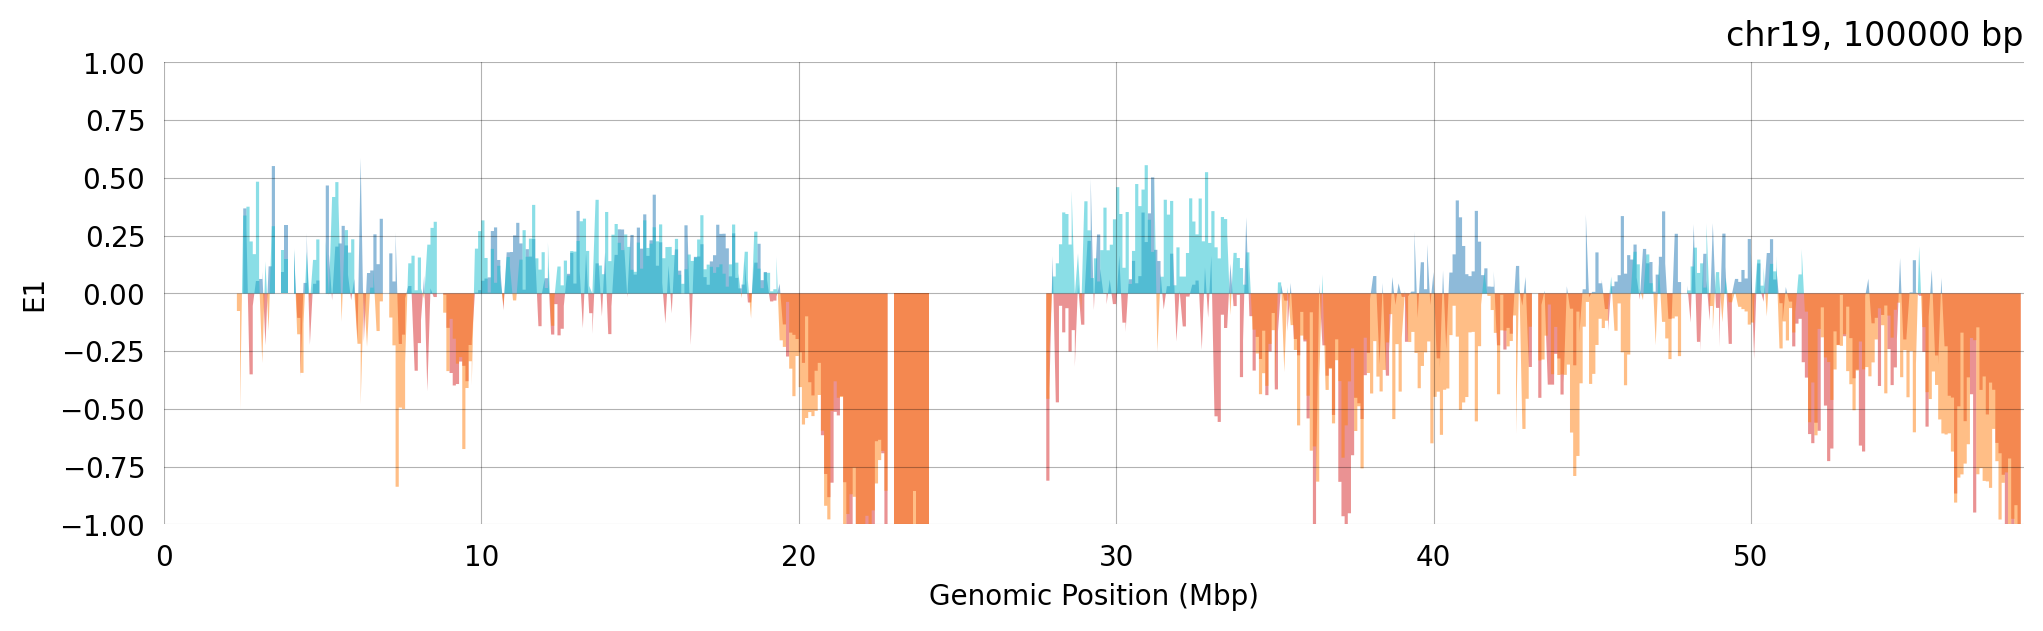

In [41]:
plot_xy_eigs(next(chroms), resolution=100000);

In [42]:
plot_xy_eigs(next(chroms), resolution=100000);

In [43]:
plot_xy_eigs(next(chroms), resolution=100000);

In [44]:
plot_xy_eigs(next(chroms), resolution=100000);

#### Check the valid interaction counts

In [169]:
import cooler
import glob
import os

mclrs = glob.glob("../../data/human_sperm_haplo_seperated/sperm_X.merged.mcool")
clrs = [f"{mcl}::/resolutions/100000" for mcl in mclrs]

for clr in clrs:
    tmp_clr = cooler.Cooler(clr)
    print(f"""\
{os.path.basename(clr.split('::')[0])}:
    n_chrX contacts: {tmp_clr.pixels().fetch("chrX")['count'].sum():,}\
""")
    
